<a href="https://colab.research.google.com/github/nhjung-phd/FactorBasedDRL/blob/main/Factor_based_DRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [PyPortfolioOpt]


In [ ]:
!pip install shimmy>=0.2.1

In [ ]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 30.0 MB/s  0:00:09
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 24.1 MB/s  0:00:18
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 39.2 MB/s  0:00:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.4 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 50.7 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 60.9 MB/s  0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 61.3 MB/s  0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.6 MB/s  0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12

In [ ]:
# 필요한 패키지 불러오기
import os
import math
import time
import datetime

# Factor Based DRL

In [ ]:
import gym
import numpy as np
import pandas as pd
import yfinance as yf
import shap

import matplotlib.pyplot as plt
from gym import spaces
from stable_baselines3 import PPO, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random
from sklearn.linear_model import LinearRegression  # 추가
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from scipy.stats import ttest_ind, mannwhitneyu

from pypfopt import expected_returns, risk_models
from pypfopt.efficient_frontier import EfficientFrontier


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [ ]:
import time

# Start Time
start_time = time.time()

# sleep (예: 1초 대기)
time.sleep(1)

time.strftime('%y%m%d - %X')

'250808 - 11:53:51'

In [ ]:
# Seed setting
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

show_summary = True

In [ ]:
#start_date ='2014-09-17' # 롤링연산으로 인해 이전20+60일 이전데이터 필요
start_date ='2014-10-21' # rolling 30 days
end_date ='2025-06-30'
# period
# 2018-01-02 ~ 2025-06-27
#[Train period: 2018-01-02 ~ 2023-03-27]
#[Test period: 2023-03-28 ~ 2025-06-27]
rolling_windows = 30

In [ ]:
def compute_returns(price_df):
    return np.log(price_df / price_df.shift(1)).dropna()

def compute_factors(price_df):
    factors = pd.DataFrame(index=price_df.index)
    for col in price_df.columns:
        price = price_df[col]
        momentum = price.pct_change(10)
        volatility = price.pct_change().rolling(window=20).std()
        ma_dev = (price - price.rolling(window=20).mean()) / price.rolling(window=20).mean()
        z_score = (price - price.rolling(window=20).mean()) / price.rolling(window=20).std()

        factors[f"{col}_mom"] = momentum
        factors[f"{col}_vol"] = volatility
        factors[f"{col}_ma"] = ma_dev
        factors[f"{col}_volz"] = z_score

    return factors.dropna()

def fetch_data_all(assets, start=start_date, end=end_date, split_ratio=0.7, show_summary=True):
    import yfinance as yf
    import numpy as np
    import pandas as pd

    # tatal data download (price + volume)
    data = yf.download(assets, start=start, end=end, auto_adjust=True, progress=False, threads=False)
    price = data["Close"].ffill().bfill().dropna()
    volume = data["Volume"].ffill().bfill().dropna()

    # returns, momentum, volatility
    returns = price.pct_change().dropna()
    momentum = price.pct_change(20)
    volatility = returns.rolling(20).std()
    factors = pd.concat([
        momentum.add_suffix("_momentum"),
        volatility.add_suffix("_volatility")
    ], axis=1)

    # 시간가변 베타 계산
    beta_df = compute_rolling_beta(price, volume)

    # factor combine
    combined_factors = pd.concat([factors, beta_df], axis=1).dropna()

    # index setting
    idx = price.index.intersection(combined_factors.index).intersection(returns.index)
    price, returns, combined_factors = price.loc[idx], returns.loc[idx], combined_factors.loc[idx]

    # time series split
    split_index = int(len(price) * split_ratio)
    split_date = price.index[split_index]


    price_train = price.iloc[:split_index]
    price_test = price.iloc[split_index:]

    returns_train = returns.iloc[:split_index]
    returns_test = returns.iloc[split_index:]

    factors_train = combined_factors.iloc[:split_index]
    factors_test = combined_factors.iloc[split_index:]


    # 🔍 summary
    if show_summary:
        train_days = len(price_train)
        test_days = len(price_test)
        total_days = train_days + test_days

        train_ratio = train_days / total_days * 100
        test_ratio = test_days / total_days * 100

        print(f"\n[Train period: {price_train.index[0].date()} ~ {price_train.index[-1].date()}] "
              f"({train_days} trading days, {train_ratio:.1f}%)")
        print(f"[Test period: {price_test.index[0].date()} ~ {price_test.index[-1].date()}] "
              f"({test_days} trading days, {test_ratio:.1f}%)")

        print("\n[Train Summary: Price]")
        print(price_train.describe().T.round(4))
        print("\n[Test Summary: Price]")
        print(price_test.describe().T.round(4))

    return (price_train, returns_train, factors_train), (price_test, returns_test, factors_test)

def fetch_data(assets, start=start_date, end=end_date, split_ratio=0.7, show_summary=True):
    import yfinance as yf
    import numpy as np
    import pandas as pd

    # 1. 데이터 다운로드
    data = yf.download(assets, start=start, end=end, auto_adjust=True, progress=False, threads=False)
    price = data["Close"].ffill().bfill().dropna()
    volume = data["Volume"].ffill().bfill().dropna()

    # 2. 주말 제거 (가상자산만 있을 때만 수행)
    crypto_set = {"BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD"}
    is_crypto_only = set(assets).issubset(crypto_set)

    #if is_crypto_only:
    # AAPL 기준 주식시장 영업일 확보
    aapl_data = yf.download("AAPL", start=start, end=end, auto_adjust=True, progress=False, threads=False)
    if aapl_data.empty or "Close" not in aapl_data:
        print("[경고] AAPL 기준 데이터가 존재하지 않아 주말 제거를 생략합니다.")
    else:
        stock_days = aapl_data["Close"].dropna().index
        price = price.loc[price.index.isin(stock_days)]
        volume = volume.loc[volume.index.isin(stock_days)]


    # 3. 팩터 계산
    returns = price.pct_change().dropna()
    momentum = price.pct_change(20)
    volatility = returns.rolling(20).std()
    factors = pd.concat([
        momentum.add_suffix("_momentum"),
        volatility.add_suffix("_volatility")
    ], axis=1)

    beta_df = compute_rolling_beta(price, volume)
    combined_factors = pd.concat([factors, beta_df], axis=1).dropna()

    # 4. 인덱스 정렬 및 정합성
    idx = price.index.intersection(combined_factors.index).intersection(returns.index)
    price, returns, combined_factors = price.loc[idx], returns.loc[idx], combined_factors.loc[idx]

    # 5. 학습/테스트 분할
    split_index = int(len(price) * split_ratio)
    price_train, price_test = price.iloc[:split_index], price.iloc[split_index:]
    returns_train, returns_test = returns.iloc[:split_index], returns.iloc[split_index:]
    factors_train, factors_test = combined_factors.iloc[:split_index], combined_factors.iloc[split_index:]

    # 6. 요약 출력
    if show_summary:
        train_days = len(price_train)
        test_days = len(price_test)
        total_days = train_days + test_days
        print(f"\n[Train period: {price_train.index[0].date()} ~ {price_train.index[-1].date()}] "
              f"({train_days} trading days, {train_days / total_days * 100:.1f}%)")
        print(f"[Test period: {price_test.index[0].date()} ~ {price_test.index[-1].date()}] "
              f"({test_days} trading days, {test_days / total_days * 100:.1f}%)")
        print("\n[Train Summary: Price]")
        print(price_train.describe().T.round(4))
        print("\n[Test Summary: Price]")
        print(price_test.describe().T.round(4))

    return (price_train, returns_train, factors_train), (price_test, returns_test, factors_test)


In [ ]:
# asset
# 📁 equity (Big Tech + S&P/Dow )
equity_assets = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOGL", # Alphabet (Google)
    "AMZN",  # Amazon
    "META",  # Meta (Facebook)
    "TSLA",  # Tesla
    "NVDA",  # Nvidia
    "NFLX",  # Netflix
    "JPM",   # JPMorgan Chase
    "V",     # Visa
    "DIS",   # Disney
    "INTC",  # Intel
    "BA",    # Boeing
    "XOM",   # Exxon Mobil
    "JNJ",   # Johnson & Johnson
    "KO",    # Coca-Cola
    "PG",    # Procter & Gamble
    "WMT",   # Walmart
    "UNH",   # UnitedHealth Group

    "SPY",  # S&P 500 ETF
    "QQQ",  # NASDAQ 100 ETF
    "DIA",  # Dow Jones ETF
]

# 📁 ETF
etf_assets = [
    "SPY",  # S&P 500 ETF
    "QQQ",  # NASDAQ 100 ETF
    "DIA",  # Dow Jones ETF
]


# 📁 Crypto Currencies
crypto_assets = [
    "BTC-USD",  # Bitcoin
    "ETH-USD",  # Ethereum
    "BNB-USD",  # Binance Coin
    "SOL-USD",  # Solana
]

# 📁 Crypto Currencies
crypto_assets2 = [
    "BTC-USD",  # Bitcoin
]


# macro asset
macro_assets = [
    # 채권 및 금리 관련
    "TLT",     # iShares 20+ Year Treasury Bond ETF
    "IEF",     # iShares 7-10 Year Treasury Bond ETF
#    "^TNX",    # CBOE 10-Year Treasury Yield Index (미국 10년물 수익률)
#    "^IRX",    # CBOE 13-week Treasury Bill Yield

    # commodity
    "GLD",     # SPDR Gold Shares (금)
    "SLV",     # iShares Silver Trust (은)
#    "USO",     # United States Oil Fund (原油)
#    "DBB",     # Invesco DB Base Metals Fund (금속)
#    "DBC",     # Invesco DB Commodity Index Tracking Fund (종합 원자재)

    # inflation
    "TIP",     # iShares TIPS Bond ETF (물가연동채)
]

# 📁 multi asset
multi_assets = equity_assets + crypto_assets2+ macro_assets
print(equity_assets)
print(crypto_assets)
print(crypto_assets2)
print(macro_assets)
print(multi_assets)

['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'NFLX', 'JPM', 'V', 'DIS', 'INTC', 'BA', 'XOM', 'JNJ', 'KO', 'PG', 'WMT', 'UNH', 'SPY', 'QQQ', 'DIA']
['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD']
['BTC-USD']
['TLT', 'IEF', 'GLD', 'SLV', 'TIP']
['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'NFLX', 'JPM', 'V', 'DIS', 'INTC', 'BA', 'XOM', 'JNJ', 'KO', 'PG', 'WMT', 'UNH', 'SPY', 'QQQ', 'DIA', 'BTC-USD', 'TLT', 'IEF', 'GLD', 'SLV', 'TIP']


In [ ]:
def compare_strategies(series1, series2, label1="A", label2="B"):
    """
    두 포트폴리오 가치 시계열에 대해 t-test와 Mann–Whitney U-test 수행
    """
    returns1 = series1.pct_change().dropna()
    returns2 = series2.pct_change().dropna()

    # 길이 맞추기
    min_len = min(len(returns1), len(returns2))
    returns1 = returns1[-min_len:]
    returns2 = returns2[-min_len:]

    # t-test
    t_stat, t_p = ttest_ind(returns1, returns2, equal_var=False)

    # Mann–Whitney U-test
    u_stat, u_p = mannwhitneyu(returns1, returns2, alternative='two-sided')

    print(f"\n🔎 [{label1} vs {label2}]")
    print(f"▶ t-test p-value: {t_p:.4f} → {'유의미함' if t_p < 0.05 else '유의미하지 않음'}")
    print(f"▶ Mann–Whitney U-test p-value: {u_p:.4f} → {'유의미함' if u_p < 0.05 else '유의미하지 않음'}")

    return {
        "t_p": t_p,
        "u_p": u_p
    }

In [ ]:
def compute_rolling_beta(price_data: pd.DataFrame, volume_data: pd.DataFrame, window: int = rolling_windows) -> pd.DataFrame:
    log_return = np.log(price_data / price_data.shift(1))
    momentum = price_data.pct_change(20)
    volatility_raw = log_return.rolling(20).std()
    volatility_score = 1 / (1 + volatility_raw)

    ma = price_data.rolling(20).mean()
    ma_deviation = (price_data - ma) / ma

    volume_z_raw = (volume_data - volume_data.rolling(20).mean()) / volume_data.rolling(20).std()
    volume_z_score = 1 / (1 + volume_z_raw.abs())

    beta_data = {}
    asset_list = price_data.columns
    n_assets = len(asset_list)

    for asset in asset_list:
        asset_df = pd.DataFrame({
            "y": log_return[asset],
            "momentum": momentum[asset],
            "volatility": volatility_score[asset],
            "ma_dev": ma_deviation[asset],
            "volume": volume_z_score[asset]
        }).dropna()

        betas = []
        index_list = []

        for i in range(window, len(asset_df)):
            y = asset_df["y"].iloc[i - window:i].values
            X = asset_df[["momentum", "volatility", "ma_dev", "volume"]].iloc[i - window:i].values
            price_window = price_data[asset].iloc[i - window:i]
            returns = price_window.pct_change().dropna()

            if np.any(np.isnan(X)) or np.any(np.isnan(y)) or returns.empty:
                betas.append([np.nan] * 7)
                index_list.append(asset_df.index[i])
                continue

            reg = LinearRegression().fit(X, y)
            sharpe = returns.mean() / (returns.std() + 1e-6)
            cumulative = (1 + returns).cumprod()
            peak = cumulative.cummax()
            drawdown = (cumulative - peak) / peak
            mdd = drawdown.min()
            beta_mdd = 1 - abs(mdd)

            # EqualWeight 유사도 (가격 기반)
            weights_price = price_data.iloc[i - 1] / price_data.iloc[i - 1].sum()
            eqw = 1 / n_assets
            eqw_similarity_price = 1 - abs(weights_price[asset] - eqw)  # 1에 가까울수록 EW에 유사

            # EqualWeight 유사도 (정책 기반)
            action_t = np.zeros(n_assets)
            action_t[list(price_data.columns).index(asset)] = 1.0  # 단일 자산 투자 가정
            weights_eqw = np.ones(n_assets) / n_assets
            eqw_similarity_policy = 1 - np.linalg.norm(action_t - weights_eqw)

            # 팩터 저장
            betas.append(list(reg.coef_) + [sharpe, beta_mdd, eqw_similarity_price, eqw_similarity_policy])
            index_list.append(asset_df.index[i])

        # 컬럼명을 언더스코어로 변경
        beta_df = pd.DataFrame(
            betas,
            columns=[
                f"{asset}_beta_momentum", f"{asset}_beta_volatility", f"{asset}_beta_ma", f"{asset}_beta_volume",
                f"{asset}_beta_sharpe", f"{asset}_beta_mdd",
                f"{asset}_beta_eqw_price", f"{asset}_beta_eqw_policy"
            ],
            index=index_list
        )
        beta_data[asset] = beta_df

    beta_panel = pd.concat(beta_data, axis=1)
    #beta_panel.columns = [f"{a}_{b}" for a, b in beta_panel.columns]  # ✅ 여기 추가
    beta_panel.columns = [b for a, b in beta_panel.columns]
    beta_panel.index.name = "Date"
    return beta_panel


In [ ]:
def equal_weight_backtest(price, transaction_cost=0.001):
    """
    매일 리밸런싱 + 수수료 반영 + 자산 보유량 기반 백테스트
    """
    returns = price.pct_change().dropna()
    n_assets = returns.shape[1]
    weights = np.ones(n_assets) / n_assets
    portfolio_values = []
    asset_quantity = np.zeros(n_assets)
    cash = 1000000  # 초기 자본

    for t in range(1, len(returns)):
        prices_today = price.iloc[t - 1].values
        total_value = cash + np.sum(asset_quantity * prices_today)

        desired_value = total_value * weights
        current_value = asset_quantity * prices_today
        trade_value = desired_value - current_value

        turnover = np.sum(np.abs(trade_value))
        cost = turnover * transaction_cost

        # 거래 반영
        net_trade_value = trade_value - np.sign(trade_value) * cost / n_assets
        asset_quantity += net_trade_value / prices_today
        cash = total_value - np.sum(asset_quantity * prices_today) - cost

        # 하루 후 가치 계산
        prices_next = price.iloc[t].values
        portfolio_value = cash + np.sum(asset_quantity * prices_next)
        portfolio_values.append(portfolio_value)

    return pd.Series(portfolio_values, index=returns.index[1:])

In [ ]:
def mvp_daily_rebalancing(price, lookback=rolling_windows, transaction_cost=0.001):
    """
    MVP 전략 기반 일일 리밸런싱 백테스트 (정확한 리밸런싱 반영)
    """
    returns = price.pct_change().dropna()
    portfolio_values = []
    asset_quantity = np.zeros(len(price.columns))
    cash = 1000000

    for t in range(lookback, len(price) - 1):
        window_price = price.iloc[t - lookback:t]
        price_today = price.iloc[t].values

        try:
            mu = expected_returns.mean_historical_return(window_price, frequency=252)
            S = risk_models.sample_cov(window_price, frequency=252)
            ef = EfficientFrontier(mu, S)
            ef.min_volatility()
            weights = ef.clean_weights()
            w = np.array([weights.get(ticker, 0.0) for ticker in price.columns])
        except:
            w = np.ones(len(price.columns)) / len(price.columns)

        total_value = cash + np.sum(asset_quantity * price_today)

        desired_value = w * total_value
        current_value = asset_quantity * price_today
        trade_value = desired_value - current_value

        # 수수료 계산 및 반영
        turnover = np.sum(np.abs(trade_value))
        cost = turnover * transaction_cost

        asset_quantity += trade_value / price_today
        cash = total_value - np.sum(asset_quantity * price_today) - cost

        # 다음 날 포트폴리오 가치
        price_next = price.iloc[t + 1].values
        portfolio_value = cash + np.sum(asset_quantity * price_next)

        portfolio_values.append(portfolio_value)

    index = price.index[lookback + 1:]
    return pd.Series(portfolio_values, index=index)

In [ ]:
def check_price_format(price: pd.DataFrame, plot_sample: bool = True, verbose: bool = True) -> str:
    """
    가격 데이터의 형식을 판단합니다: 'raw_price', 'cumulative_return', 'return'
    - plot_sample: True일 경우 샘플 자산의 꺾은선 그래프를 출력
    - verbose: True일 경우 통계 정보를 출력
    """
    price = price.dropna()
    mean_val = price.mean().mean()
    std_val = price.std().mean()
    min_val = price.min().min()
    max_val = price.max().max()

    # 판단 기준
    if (min_val > 10) and (std_val > 5):
        format_type = "raw_price"
    elif (min_val > 0.5) and (max_val < 2.0) and (std_val > 0.01):
        format_type = "cumulative_return"
    elif (mean_val < 0.05) and (std_val < 0.1):
        format_type = "return"
    else:
        format_type = "ambiguous"

    if verbose:
        print(f"▶ 평균: {mean_val:.4f}, 표준편차: {std_val:.4f}, 최소값: {min_val:.4f}, 최대값: {max_val:.4f}")
        print(f"→ 판단된 형식: {format_type}")

    if plot_sample:
        sample_asset = price.columns[0]
        price[sample_asset].plot(title=f"Sample Asset: {sample_asset} ({format_type})", figsize=(10, 4))
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return format_type

def equal_weight_buy_and_hold(price: pd.DataFrame, transaction_cost: float = 0.001) -> pd.Series:
    """
    Equal Weight Buy & Hold 전략 (리밸런싱 없음)
    - 초기 자산을 동일 비중으로 각 자산에 분배 후 보유
    - 수수료는 최초 매수 시점에만 적용
    """
    # 가격 데이터가 제대로 되어 있는지 확인
    format_type = check_price_format(price)
    print(format_type)

    n_assets = price.shape[1]
    price = price.dropna()
    start_price = price.iloc[0].values

    weights = np.ones(n_assets) / n_assets
    total_value = 1.0
    turnover = np.sum(np.abs(weights * total_value))
    cost = turnover * transaction_cost
    effective_value = total_value - cost

    # 초기 매수
    desired_value = weights * effective_value
    asset_quantity = desired_value / start_price

    portfolio_values = []
    for t in range(len(price)):
        price_today = price.iloc[t].values
        port_val = np.sum(asset_quantity * price_today)
        portfolio_values.append(port_val)

    return pd.Series(portfolio_values, index=price.index)

In [ ]:
# performance_metrics
def performance_metrics(series):
    returns = series.pct_change().dropna()
    cumulative_return = series.iloc[-1] / series.iloc[0] - 1
    annualized_return = (series.iloc[-1] / series.iloc[0]) ** (252 / len(series)) - 1
    cagr = annualized_return  # 중복 제거
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = (cagr - 0.0) / (annualized_vol + 1e-6)
    downside_std = returns[returns < 0].std() * np.sqrt(252)
    sortino = (cagr - 0.0) / (downside_std + 1e-6)
    peak = series.cummax()
    drawdown = (series - peak) / peak
    mdd = drawdown.min()
    mdd = drawdown.min()
    if len(returns) == 0:
        turnover = 0.0
    else:
        turnover = (np.abs(returns).sum()) / len(returns)

    return {
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Cumulative Return": cumulative_return,
        "Annualized Return": cagr,
        "Annualized Volatility": annualized_vol,
        "CAGR": cagr,
        "Maximum Drawdown": mdd,
        "Turnover Ratio": turnover
    }

In [ ]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
from gym.utils import seeding

TRANSACTION_FEE_PERCENT = 0.001
INITIAL_ACCOUNT_BALANCE = 1000000
HMAX_NORMALIZE = 10

class PPOPortfolioEnv(gym.Env):
    def __init__(self, returns, factors, price, objective="sharpe"):
        self.returns = returns
        self.factors = factors
        self.price = price
        self.df = price
        self.objective = objective

        self.equity_dim = self.returns.shape[1]
        self.day = 0
        self.terminal = False

        self.action_space = spaces.Box(low=-1, high=1, shape=(self.equity_dim,))
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(2*self.equity_dim+1,))

        self.state = [INITIAL_ACCOUNT_BALANCE] + self.price.iloc[self.day].tolist() + [0]*self.equity_dim
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.portfolio_returns = []
        self.actions_memory = [[1/self.equity_dim]*self.equity_dim]
        self.portfolio_value = [INITIAL_ACCOUNT_BALANCE]


        self._seed()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _normalize(self, weights):
        norm = np.sum(weights)
        return weights / (norm + 1e-15)

    def _calculate_portfolio_value(self):
        return self.state[0] + sum(
            np.array(self.state[1:self.equity_dim+1]) * np.array(self.state[self.equity_dim+1:])
        )

    def _calculate_reward(self, begin_val, end_val):
        ret = (end_val - begin_val) / (begin_val + 1e-8)
        self.portfolio_returns.append(ret)

        if self.objective == "sharpe":
            if len(self.portfolio_returns) > 20:
                mean_ret = np.mean(self.portfolio_returns)
                std_ret = np.std(self.portfolio_returns)
                return mean_ret / (std_ret + 1e-6)
            elif len(self.portfolio_returns) > 1:
                return np.prod(1 + np.array(self.portfolio_returns)) - 1
            else:
                return 0
        elif self.objective == "return":
            return ret
        else:
            return 0

    def _sell_equity(self, index, action):
        action = np.floor(action)
        if self.state[index + self.equity_dim + 1] > 0:
            sell_amount = min(abs(action), self.state[index + self.equity_dim + 1])
            self.state[0] += self.state[index + 1] * sell_amount * (1 - TRANSACTION_FEE_PERCENT)
            self.state[index + self.equity_dim + 1] -= sell_amount

    def _buy_equity(self, index, action):
        action = np.floor(action)
        cost = self.state[index + 1] * action * (1 + TRANSACTION_FEE_PERCENT)
        if self.state[0] >= cost:
            self.state[0] -= cost
            self.state[index + self.equity_dim + 1] += action

    #샤프지수 계산을 위한 함수
    def _calculate_sharpe_ratio(self, begin_portfolio_value,end_portfolio_value):
        #print('_calculate_sharpe_ratio')
        returns = np.array([begin_portfolio_value, end_portfolio_value])
        returns = returns[~np.isnan(returns)]  # NaN 값을 제거
        if len(returns) == 0:
            returns = np.array([0.0])  # 변동성이 0인 경우 대비

        risk_free_rate = 0.02  # 필요한 값으로 설정하세요

        returns_tensor = torch.tensor(returns)  # numpy 배열을 토치 텐서로 변환
        mean_return = returns_tensor.mean()
        std_return = returns_tensor.std()

        # 표준편차가 0인 경우 대비하여 0이 아닌 값을 사용
        std_return = max(std_return, 1e-6)

        # 분모가 0인 경우에 대한 처리 추가
        if std_return > 0:
            sharpe_ratio = (mean_return - risk_free_rate) / std_return
            sharpe_ratio = sharpe_ratio.item()
            #print('sharpe_ratio=',sharpe_ratio)
        else:
            sharpe_ratio = 0.0  # 혹은 원하는 다른 값을 사용

        return sharpe_ratio

    # 소르티노 지수 계산을 위한 함수
    def _calculate_sortino_ratio(self, begin_portfolio_value,end_portfolio_value):
        #print('_calculate_sortino_ratio')
        returns = np.array([begin_portfolio_value, end_portfolio_value])
        returns = returns[~np.isnan(returns)]  # NaN 값을 제거

        if len(returns) == 0:
            returns = np.array([0.0])  # 변동성이 0인 경우 대비

        risk_free_rate = 0.02

        returns_tensor = torch.tensor(returns)  # numpy 배열을 토치 텐서로 변환
        mean_return = returns_tensor.mean()

        downside_returns = returns[returns < risk_free_rate]
        downside_returns_tensor = torch.tensor(downside_returns)  # numpy 배열을 토치 텐서로 변환

        if len(downside_returns) == 0:
            downside_deviation = 0.0
        else:
            downside_deviation = downside_returns_tensor.std()

        # 표준편차가 0인 경우 대비하여 0이 아닌 값을 사용
        downside_deviation = max(downside_deviation, 1e-6)

        if downside_deviation > 0.0:
            #print('mean_return=',mean_return, 'risk_free_rate=',risk_free_rate, 'downside_deviation=',downside_deviation)
            sortino_ratio = (mean_return - risk_free_rate) / downside_deviation
            #print('sortino_ratio=',sortino_ratio)
            sortino_ratio = sortino_ratio.item()
        else:
            sortino_ratio = 0.0

        return sortino_ratio

    # tangent portfolio
    def _calculate_tangent_portfolio_reward(self, begin_portfolio_value, end_portfolio_value):
        reward = 0.0

        return reward

    # ✅ 공통 유틸: 베타 점수 계산 및 보상 반환

    def _calculate_beta_reward(self, predicted_weights, factor_type, negate=False):
        idx = max(self.day - 1, 0)
        beta_scores = []
        for asset in self.price.columns:
            col_name = f"{asset}_{factor_type}"
            beta_value = self.factors.iloc[idx].get(col_name, 0)
            beta_scores.append(beta_value)

        beta_scores = np.array(beta_scores)
        predicted_weights = self._normalize(predicted_weights)
        reward = np.dot(predicted_weights, beta_scores)
        return -reward if negate else reward

    def _calculate_multi_beta_reward(self, predicted_weights):
        idx = max(self.day - 1, 0)  # 또는 self.current_step - 1, 둘 중 실제 클래스에 맞는 이름 사용
        beta_scores = []
        beta_factors = {
            "momentum": +1,
            "volatility": -1,
            "ma": +1,
            "volume": -1,
            "sharpe": +1,
            "mdd": +1,               # drawdown 적을수록 좋으나 beta는 1-|MDD| 형태로 되어 있으므로 +1 유지
            "eqw_price": -1,         # price 비중이 EW에 가까울수록 좋다면 → -1 (편차 작을수록)
            "eqw_policy": -1         # action이 EW에 가까울수록 좋다면 → -1
        }

        for asset in self.price.columns:  # 또는 self.assets 사용
            beta_total = 0
            found_factors = 0
            for factor_name, direction in beta_factors.items():
                col_name = f"{asset}_beta_{factor_name}"
                if col_name in self.factors.columns:
                    beta_val = self.factors.iloc[idx].get(col_name, 0)
                    beta_total += direction * beta_val
                    found_factors += 1
                else:
                    print(f"[경고] 누락된 팩터: {col_name}")

            if found_factors > 0:
                beta_scores.append(beta_total / found_factors)
            else:
                beta_scores.append(0.0)

        beta_scores = np.array(beta_scores)
        predicted_weights = self._normalize(predicted_weights)
        reward = np.dot(predicted_weights, beta_scores)

        return reward

    def _calculate_p_adaptive_reward(self, predicted_weights):
        idx = max(self.day - 1, 0)
        factor_list = ["momentum", "volatility", "ma", "volume", "sharpe", "mdd", "eqw_price", "eqw_policy"]
        current_scores = []
        eqw_scores = []

        for factor in factor_list:
            current_score = 0.0
            eqw_score = 0.0
            count = 0

            for i, asset in enumerate(self.price.columns):  # 또는 self.assets 사용
                col_name = f"{asset}_beta_{factor}"
                if col_name in self.factors.columns:
                    beta_val = self.factors.iloc[idx].get(col_name, 0)
                    current_score += predicted_weights[i] * beta_val
                    eqw_score += (1.0 / self.equity_dim) * beta_val
                    count += 1

            if count > 0:
                current_scores.append(current_score / count)
                eqw_scores.append(eqw_score / count)

        avg_current_score = np.mean(current_scores)
        avg_eqw_score = np.mean(eqw_scores)

        reward = avg_current_score if avg_current_score >= avg_eqw_score else avg_eqw_score

        return reward


    # 리워드 계산 및 포트폴리오 조정
    def _execute_trades(self, predicted_weights, begin_portfolio_value,end_portfolio_value):
        #print('_execute_trades')
        # 예측된 비중에 따라 주식 사고 팔기
        for index, weight in enumerate(predicted_weights):
            if weight > 0:  # 사야 할 경우
                self._buy_equity(index, weight)
            elif weight < 0:  # 팔아야 할 경우
                self._sell_equity(index, abs(weight))

        # reward_type이 1이면 샤프 지수 최대화
        if self.objective == "sharpe":
           reward = self._calculate_sharpe_ratio(begin_portfolio_value,end_portfolio_value)
        # reward_type이 2이면 소르티노 지수 최대화
        elif self.objective == "sortino":
           reward = self._calculate_sortino_ratio(begin_portfolio_value,end_portfolio_value)
           #print("self.reward_type..",self.reward_type,"reward=",reward)
        # reward_type 이 5인경우 tangent portfolio 비중을 구하도록
        elif self.objective == "tangent":
           reward = self._calculate_tangent_portfolio_reward(begin_portfolio_value,end_portfolio_value)
        elif self.objective == "momentum_β":
            reward = self._calculate_beta_reward(predicted_weights, "beta_mom")
        elif self.objective == "beta_vol":
            reward = self._calculate_beta_reward(predicted_weights, "beta_vol", negate=True)
        elif self.objective == "beta_ma":
            reward = self._calculate_beta_reward(predicted_weights, "beta_ma", negate=True)
        elif self.objective == "beta_sharpe":
            reward = self._calculate_beta_reward(predicted_weights, "beta_sharpe")
        elif self.objective == "beta_volz":
            reward = self._calculate_beta_reward(predicted_weights, "beta_volz")
        elif self.objective == "beta_mdd":
            reward = self._calculate_beta_reward(predicted_weights, "beta_mdd")
        elif self.objective == "beta_eqw_price":
            reward = self._calculate_beta_reward(predicted_weights, "beta_eqw_price")
        elif self.objective == "beta_eqw_policy":
            reward = self._calculate_beta_reward(predicted_weights, "beta_eqw_policy")
        elif self.objective == "static_β":
            reward = self._calculate_multi_beta_reward(predicted_weights)
        elif self.objective == "dynamic_β":
            reward = self._calculate_p_adaptive_reward(predicted_weights)

        else :
           #print("reward Error")
           reward = 0.0

        # 보상 계산: 끝 포트폴리오 샤프값 - 시작 포트폴리오 샤프값
        self.reward = reward

        return self.reward

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1

        if self.terminal:
            return self.state, self.reward, self.terminal, {}

        actions = actions * HMAX_NORMALIZE

        begin_total_asset = self.state[0] + sum(
            np.array(self.state[1:(self.equity_dim+1)]) *
            np.array(self.state[(self.equity_dim+1):(self.equity_dim*2+1)])
        )

        argsort_actions = np.argsort(actions)
        sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
        buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

        for index in sell_index:
            self._sell_equity(index, actions[index])

        for index in buy_index:
            self._buy_equity(index, actions[index])

        self.day += 1
        self.data = self.df.iloc[self.day, :]

        self.state = [self.state[0]] + self.data.values.tolist() + \
                    list(self.state[(self.equity_dim+1):(self.equity_dim*2+1)])

        end_total_asset = self.state[0] + sum(
            np.array(self.state[1:(self.equity_dim+1)]) *
            np.array(self.state[(self.equity_dim+1):(self.equity_dim*2+1)])
        )

        reward = self._execute_trades(actions, begin_total_asset, end_total_asset)
        self.reward += reward

        self.portfolio_value.append(end_total_asset)

        weights = self.normalization(np.array(self.state[(self.equity_dim+1):(self.equity_dim*2+1)]))
        self.actions_memory.append(weights.tolist())

        return self.state, self.reward, self.terminal, {}


    def reset(self):
        self.day = 0
        self.state = [INITIAL_ACCOUNT_BALANCE] + self.price.iloc[self.day].tolist() + [0]*self.equity_dim
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.portfolio_returns = []
        self.actions_memory = [[1/self.equity_dim]*self.equity_dim]
        self.portfolio_value = [INITIAL_ACCOUNT_BALANCE]
        return np.array(self.state)

    def render(self, mode="human", close=False):
        return self.state

    def save_action_memory(self):
        return self.actions_memory

    def normalization(self, actions):
        #print('normalization')
        output = actions/(np.sum(actions)+1e-15)
        return output


In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv

# 훈련 및 평가 함수 (fetch_data 함수의 훈련/테스트 분리 구조와 연계)
def train_and_evaluate(assets, algo_class, objective="sharpe"):
    # 훈련/테스트 데이터 로딩
    (price_train, returns_train, factors_train), (price_test, returns_test, factors_test) = fetch_data(
        assets, start=start_date, end=end_date, split_ratio=0.7
    )

    # 베이스라인 전략 (테스트 구간에만 적용)
    if algo_class is None:
        if objective == "equal_weights":
            return equal_weight_backtest(price_test[assets], transaction_cost=0.001)
        elif objective == "mvp":
            return mvp_daily_rebalancing(price_test[assets], lookback=rolling_windows, transaction_cost=0.001)
        elif objective == "buy_and_hold":
            return equal_weight_buy_and_hold(price_test[assets], transaction_cost=0.001)
        else:
            return None

    # DRL 학습 환경 (훈련 데이터 기반)
    print("훈련 중...")
    env_train = DummyVecEnv([lambda: PPOPortfolioEnv(returns_train, factors_train, price_train, objective)])
    model = algo_class("MlpPolicy", env_train, verbose=0, seed=SEED)
    model.learn(total_timesteps=50000)

    # DRL 평가 환경 (테스트 데이터 기반)
    print("테스트 중...")
    env_eval = PPOPortfolioEnv(returns_test, factors_test, price_test, objective)
    obs = env_eval.reset()
    done = False

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env_eval.step(action)

    # 테스트 구간 포트폴리오 가치 시계열 반환
    values = env_eval.portfolio_value
    index = price_test.index[:len(values)]
    return pd.Series(values, index=index)


In [ ]:
# Equity Asset Experiments
equity_experiments = [
    ("Equity", equity_assets, "EqualWeight", None, "equal_weights"),
    ("Equity", equity_assets, "MeanVariance", None, "mvp"),
    ("Equity", equity_assets, "PPO", PPO, "sharpe"),
    ("Equity", equity_assets, "PPO", PPO, "sortino"),
    ("Equity", equity_assets, "PPO", PPO, "momentum_β"),
    ("Equity", equity_assets, "PPO", PPO, "dynamic_β"),
    ("Equity", equity_assets, "PPO", PPO, "static_β"),
]

# Crypto Asset Experiments
Crypto_experiments = [
    ("Crypto", crypto_assets2, "EqualWeight", None, "equal_weights"),
    ("Crypto", crypto_assets2, "MeanVariance", None, "mvp"),
    ("Crypto", crypto_assets2, "PPO", PPO, "sharpe"),
    ("Crypto", crypto_assets2, "PPO", PPO, "sortino"),
    ("Crypto", crypto_assets2, "PPO", PPO, "momentum_β"),
    ("Crypto", crypto_assets2, "PPO", PPO, "dynamic_β"),
    ("Crypto", crypto_assets2, "PPO", PPO, "static_β"),
]

# Crypto Asset Experiments
Crypto_experiments_old = [
    ("Crypto", crypto_assets, "EqualWeight", None, "equal_weights"),
    ("Crypto", crypto_assets, "MeanVariance", None, "mvp"),
    ("Crypto", crypto_assets, "PPO", PPO, "sharpe"),
    ("Crypto", crypto_assets, "PPO", PPO, "sortino"),
    ("Crypto", crypto_assets, "PPO", PPO, "momentum_β"),
    ("Crypto", crypto_assets, "PPO", PPO, "dynamic_β"),
    ("Crypto", crypto_assets, "PPO", PPO, "static_β"),
]

# Macro Asset Experiments
Macro_experiments = [
    ("Macro", macro_assets, "EqualWeight", None, "equal_weights"),
    ("Macro", macro_assets, "MeanVariance", None, "mvp"),
    ("Macro", macro_assets, "PPO", PPO, "sharpe"),
    ("Macro", macro_assets, "PPO", PPO, "sortino"),
    ("Macro", macro_assets, "PPO", PPO, "momentum_β"),
    ("Macro", macro_assets, "PPO", PPO, "dynamic_β"),
    ("Macro", macro_assets, "PPO", PPO, "static_β"),
]

# Multi Asset  Experiments
Multi_experiments = [
    ("Multi", multi_assets, "EqualWeight", None, "equal_weights"),
    ("Multi", multi_assets, "MeanVariance", None, "mvp"),
    ("Multi", multi_assets, "PPO", PPO, "sharpe"),
    ("Multi", multi_assets, "PPO", PPO, "sortino"),
    ("Multi", multi_assets, "PPO", PPO, "momentum_β"),
    ("Multi", multi_assets, "PPO", PPO, "dynamic_β"),
    ("Multi", multi_assets, "PPO", PPO, "static_β"),
]

# Multi Asset All Experiments
Multi_all_experiments_sac = [
    ("Multi", multi_assets, "EqualWeight", None, "equal_weights"),
    ("Multi", multi_assets, "MeanVariance", None, "mvp"),
    ("Multi", multi_assets, "SAC", SAC, "sharpe"),
    ("Multi", multi_assets, "SAC", SAC, "sortino"),
    ("Multi", multi_assets, "SAC", SAC, "momentum_β"),
    ("Multi", multi_assets, "SAC", SAC, "dynamic_β"),
    ("Multi", multi_assets, "SAC", SAC, "static_β"),
]

# Multi Asset All Experiments
Multi_all_experiments_td3 = [
    ("Multi", multi_assets, "EqualWeight", None, "equal_weights"),
    ("Multi", multi_assets, "MeanVariance", None, "mvp"),
    ("Multi", multi_assets, "TD3", TD3, "sharpe"),
    ("Multi", multi_assets, "TD3", TD3, "sortino"),
    ("Multi", multi_assets, "TD3", TD3, "momentum_β"),
    ("Multi", multi_assets, "TD3", TD3, "dynamic_β"),
    ("Multi", multi_assets, "TD3", TD3, "static_β"),
]

# Equity Asset

▶ Running: Equity_EqualWeight_equal_weights

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
         count      mean       std       min       25%       50%       75%  \
Ticker                                                                       
AAPL    1845.0   63.5308   44.9641   20.6475   28.3542   43.2791   88.6624   
AMZN    1845.0   86.0640   51.4040   14.3475   38.6220   82.8110  137.7290   
BA      1845.0  222.0793   89.1122   95.0100  133.7385  208.3400  320.2827   
DIA     1845.0  218.4911   60.9017  127.9686  155.3646  216.8292  253.8773   
DIS     1845.0  118.0308   27.8162   82.4504   97.7316  107.0025  134.1372   
GOOGL   1845.0   64.2812   32.7287   24.7048   40.0215   55.0002   73.5136   
INTC    1845.0   38.8853   10.4100   20.3024   28.6505   40.9945   46.8853   
JNJ     1845.0  111.3771   24.1879   69.2167   92.5681  110.6248  127.7236   
JPM     1845.0   86

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Equity_PPO_sortino

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
         count      mean       std       min       25%       50%       75%  \
Ticker                                                                       
AAPL    1845.0   63.5308   44.9641   20.6475   28.3542   43.2791   88.6624   
AMZN    1845.0   86.0640   51.4040   14.3475   38.6220   82.8110  137.7290   
BA      1845.0  222.0793   89.1122   95.0100  133.7385  208.3400  320.2827   
DIA     1845.0  218.4911   60.9017  127.9686  155.3646  216.8292  253.8773   
DIS     1845.0  118.0308   27.8162   82.4504   97.7316  107.0025  134.1372   
GOOGL   1845.0   64.2812   32.7287   24.7048   40.0215   55.0002   73.5136   
INTC    1845.0   38.8853   10.4100   20.3024   28.6505   40.9945   46.8853   
JNJ     1845.0  111.3771   24.1879   69.2167   92.5681  110.6248  127.7236   
JPM     1845.0   86.6236

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Equity_PPO_momentum_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
         count      mean       std       min       25%       50%       75%  \
Ticker                                                                       
AAPL    1845.0   63.5308   44.9641   20.6475   28.3542   43.2791   88.6624   
AMZN    1845.0   86.0640   51.4040   14.3475   38.6220   82.8110  137.7290   
BA      1845.0  222.0793   89.1122   95.0100  133.7385  208.3400  320.2827   
DIA     1845.0  218.4911   60.9017  127.9686  155.3646  216.8292  253.8773   
DIS     1845.0  118.0308   27.8162   82.4504   97.7316  107.0025  134.1372   
GOOGL   1845.0   64.2812   32.7287   24.7048   40.0215   55.0002   73.5136   
INTC    1845.0   38.8853   10.4100   20.3024   28.6505   40.9945   46.8853   
JNJ     1845.0  111.3771   24.1879   69.2167   92.5681  110.6248  127.7236   
JPM     1845.0   86.6

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Equity_PPO_dynamic_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
         count      mean       std       min       25%       50%       75%  \
Ticker                                                                       
AAPL    1845.0   63.5308   44.9641   20.6475   28.3542   43.2791   88.6624   
AMZN    1845.0   86.0640   51.4040   14.3475   38.6220   82.8110  137.7290   
BA      1845.0  222.0793   89.1122   95.0100  133.7385  208.3400  320.2827   
DIA     1845.0  218.4911   60.9017  127.9686  155.3646  216.8292  253.8773   
DIS     1845.0  118.0308   27.8162   82.4504   97.7316  107.0025  134.1372   
GOOGL   1845.0   64.2812   32.7287   24.7048   40.0215   55.0002   73.5136   
INTC    1845.0   38.8853   10.4100   20.3024   28.6505   40.9945   46.8853   
JNJ     1845.0  111.3771   24.1879   69.2167   92.5681  110.6248  127.7236   
JPM     1845.0   86.62

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Equity_PPO_static_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
         count      mean       std       min       25%       50%       75%  \
Ticker                                                                       
AAPL    1845.0   63.5308   44.9641   20.6475   28.3542   43.2791   88.6624   
AMZN    1845.0   86.0640   51.4040   14.3475   38.6220   82.8110  137.7290   
BA      1845.0  222.0793   89.1122   95.0100  133.7385  208.3400  320.2827   
DIA     1845.0  218.4911   60.9017  127.9686  155.3646  216.8292  253.8773   
DIS     1845.0  118.0308   27.8162   82.4504   97.7316  107.0025  134.1372   
GOOGL   1845.0   64.2812   32.7287   24.7048   40.0215   55.0002   73.5136   
INTC    1845.0   38.8853   10.4100   20.3024   28.6505   40.9945   46.8853   
JNJ     1845.0  111.3771   24.1879   69.2167   92.5681  110.6248  127.7236   
JPM     1845.0   86.623

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
                                  Sharpe Ratio  Sortino Ratio  \
Equity_EqualWeight_equal_weights      1.031288       1.426056   
Equity_MeanVariance_mvp               0.319622       0.433105   
Equity_PPO_sharpe                     0.670406       0.889388   
Equity_PPO_sortino                    0.699619       0.929750   
Equity_PPO_momentum_β                 1.104505       1.571687   
Equity_PPO_dynamic_β                  0.915784       1.383370   
Equity_PPO_static_β                   1.078103       1.497996   

                                  Cumulative Return  Annualized Return  \
Equity_EqualWeight_equal_weights           0.782869           0.202552   
Equity_MeanVariance_mvp                    0.132150           0.041957   
Equity_PPO_sharpe                          0.284798           0.083002   
Equity_PPO_sortino                         0.299644           0.086968   
Equity_PPO_momentum_β                      0.796764           0.204965   
Equity_PPO_dynamic_β      

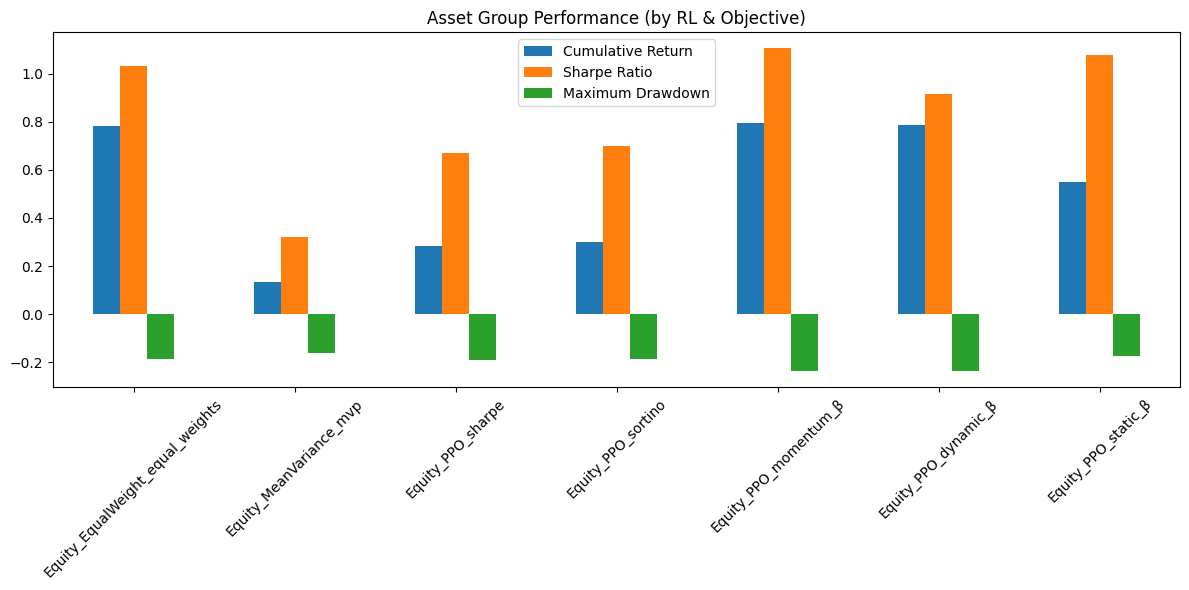

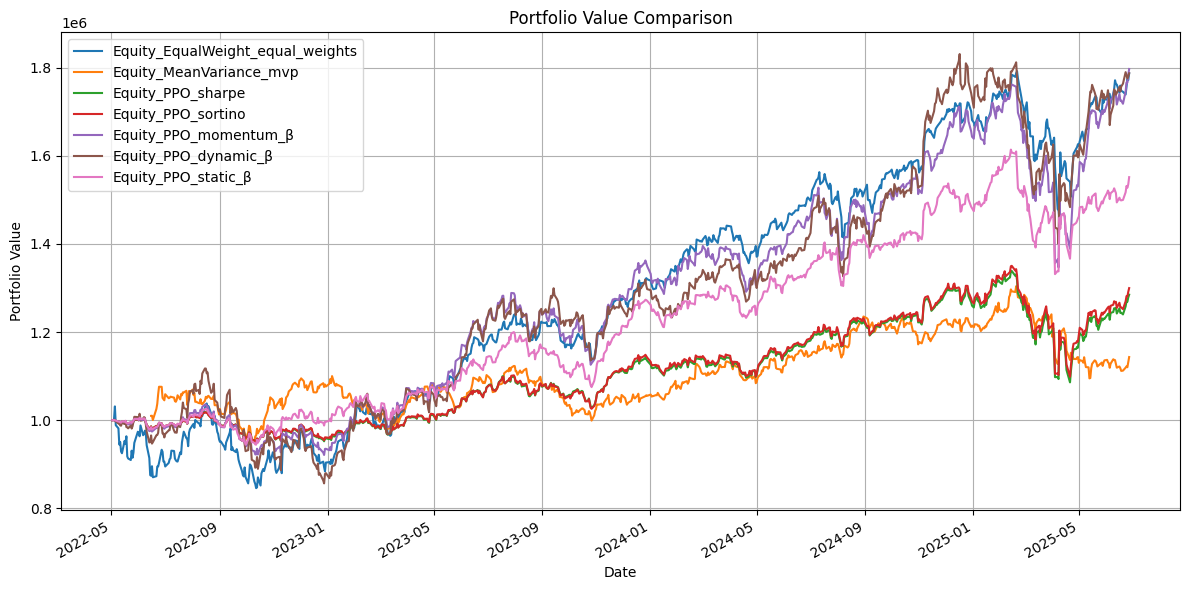

In [ ]:
 # 실험 실행
results = {}
previous_group = None

for group, assets, algo_name, algo_class, objective in equity_experiments:
    key = f"{group}_{algo_name}_{objective}"
    print(f"▶ Running: {key}")
    try:
        results[key] = train_and_evaluate(assets, algo_class, objective)
    except Exception as e:
        print(f"Error in {key}: {str(e)}")
        results[key] = None
    # 그룹이 바뀔때만 기술통계 출력
    if previous_group != group:
        show_summary = True
        previous_group = group
    else:
        show_summary = False


# 성과 요약 (오류 제외)
valid_results = {k: v for k, v in results.items() if v is not None}
metrics_table = pd.DataFrame({k: performance_metrics(v) for k, v in valid_results.items()}).T
print(metrics_table)

# 성과 막대그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 포트폴리오 가치 시계열 그래프
results_df = pd.DataFrame(valid_results)
results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# sharpe 를 baseline으로 하여 통계적으로 의미가 있는지 비교함
summary = []

for (group, assets, algo, model_cls, obj) in equity_experiments:
    if obj == "sharpe":
        continue  # baseline 제외

    base_key = f"{group}_{algo}_sharpe"
    compare_key = f"{group}_{algo}_{obj}"

    # Add check for None before calling compare_strategies
    if base_key in results and compare_key in results and results[base_key] is not None and results[compare_key] is not None:
        res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
        summary.append({
            "Group": group,
            "Algorithm": algo,
            "CompareWith": obj,
            "t_p": res["t_p"],
            "u_p": res["u_p"]
        })

summary_df = pd.DataFrame(summary)
#import ace_tools as tools; tools.display_dataframe_to_user(name="Comparison Results", dataframe=summary_df)
print(summary_df)


🔎 [Equity_PPO_sharpe vs Equity_PPO_sortino]
▶ t-test p-value: 0.9700 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.9477 → 유의미하지 않음

🔎 [Equity_PPO_sharpe vs Equity_PPO_momentum_β]
▶ t-test p-value: 0.3554 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.2208 → 유의미하지 않음

🔎 [Equity_PPO_sharpe vs Equity_PPO_dynamic_β]
▶ t-test p-value: 0.3947 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.2900 → 유의미하지 않음

🔎 [Equity_PPO_sharpe vs Equity_PPO_static_β]
▶ t-test p-value: 0.5546 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.4314 → 유의미하지 않음
    Group Algorithm CompareWith       t_p       u_p
0  Equity       PPO     sortino  0.969998  0.947694
1  Equity       PPO  momentum_β  0.355447  0.220789
2  Equity       PPO   dynamic_β  0.394656  0.289953
3  Equity       PPO    static_β  0.554645  0.431405


In [ ]:
summary = []

for (group, assets, algo, model_cls, obj) in equity_experiments:
    if obj == "equal_weights":
        continue

    base_key = f"{group}_EqualWeight_equal_weights"  # EqualWeight로 고정
    compare_key = f"{group}_{algo}_{obj}"


    print(">> base:", base_key, "| compare:", compare_key)

    if base_key in results and compare_key in results:
        if results[base_key] is not None and results[compare_key] is not None:
            res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
            summary.append({
                "Group": group,
                "Algorithm": algo,
                "CompareWith": obj,
                "t_p": res["t_p"],
                "u_p": res["u_p"]
            })

        else:
            print(">> One of the results is None")
    else:
        print(">> Key missing in results")

summary_df = pd.DataFrame(summary)
print(summary_df)


>> base: Equity_EqualWeight_equal_weights | compare: Equity_MeanVariance_mvp

🔎 [Equity_EqualWeight_equal_weights vs Equity_MeanVariance_mvp]
▶ t-test p-value: 0.1194 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.1179 → 유의미하지 않음
>> base: Equity_EqualWeight_equal_weights | compare: Equity_PPO_sharpe

🔎 [Equity_EqualWeight_equal_weights vs Equity_PPO_sharpe]
▶ t-test p-value: 0.3751 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.1648 → 유의미하지 않음
>> base: Equity_EqualWeight_equal_weights | compare: Equity_PPO_sortino

🔎 [Equity_EqualWeight_equal_weights vs Equity_PPO_sortino]
▶ t-test p-value: 0.3911 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.1821 → 유의미하지 않음
>> base: Equity_EqualWeight_equal_weights | compare: Equity_PPO_momentum_β

🔎 [Equity_EqualWeight_equal_weights vs Equity_PPO_momentum_β]
▶ t-test p-value: 0.9989 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.9214 → 유의미하지 않음
>> base: Equity_EqualWeight_equal_weights | compare: Equity_PPO_dynamic_β

🔎 [Equity_EqualWeight_equal_weights vs Equi

# Crypto Asset

▶ Running: Crypto_EqualWeight_equal_weights

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean        std      min      25%        50%  \
Ticker                                                                
BTC-USD  1845.0  12559.8895  16774.007  178.103  704.376  6639.1401   

               75%         max  
Ticker                          
BTC-USD  11322.123  67566.8281  

[Test Summary: Price]
         count        mean         std         min        25%         50%  \
Ticker                                                                      
BTC-USD  792.0  49390.9594  28459.6425  15787.2842  25825.189  37869.5371   

                75%          max  
Ticker                            
BTC-USD  67917.6445  111673.2812  
▶ Running: Crypto_MeanVariance_mvp

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-0

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Crypto_PPO_sortino

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean        std      min      25%        50%  \
Ticker                                                                
BTC-USD  1845.0  12559.8895  16774.007  178.103  704.376  6639.1401   

               75%         max  
Ticker                          
BTC-USD  11322.123  67566.8281  

[Test Summary: Price]
         count        mean         std         min        25%         50%  \
Ticker                                                                      
BTC-USD  792.0  49390.9594  28459.6425  15787.2842  25825.189  37869.5371   

                75%          max  
Ticker                            
BTC-USD  67917.6445  111673.2812  
훈련 중...


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Crypto_PPO_momentum_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean        std      min      25%        50%  \
Ticker                                                                
BTC-USD  1845.0  12559.8895  16774.007  178.103  704.376  6639.1401   

               75%         max  
Ticker                          
BTC-USD  11322.123  67566.8281  

[Test Summary: Price]
         count        mean         std         min        25%         50%  \
Ticker                                                                      
BTC-USD  792.0  49390.9594  28459.6425  15787.2842  25825.189  37869.5371   

                75%          max  
Ticker                            
BTC-USD  67917.6445  111673.2812  
훈련 중...


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Crypto_PPO_dynamic_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean        std      min      25%        50%  \
Ticker                                                                
BTC-USD  1845.0  12559.8895  16774.007  178.103  704.376  6639.1401   

               75%         max  
Ticker                          
BTC-USD  11322.123  67566.8281  

[Test Summary: Price]
         count        mean         std         min        25%         50%  \
Ticker                                                                      
BTC-USD  792.0  49390.9594  28459.6425  15787.2842  25825.189  37869.5371   

                75%          max  
Ticker                            
BTC-USD  67917.6445  111673.2812  
훈련 중...


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Crypto_PPO_static_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean        std      min      25%        50%  \
Ticker                                                                
BTC-USD  1845.0  12559.8895  16774.007  178.103  704.376  6639.1401   

               75%         max  
Ticker                          
BTC-USD  11322.123  67566.8281  

[Test Summary: Price]
         count        mean         std         min        25%         50%  \
Ticker                                                                      
BTC-USD  792.0  49390.9594  28459.6425  15787.2842  25825.189  37869.5371   

                75%          max  
Ticker                            
BTC-USD  67917.6445  111673.2812  
훈련 중...


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
                                  Sharpe Ratio  Sortino Ratio  \
Crypto_EqualWeight_equal_weights      0.723065       1.035075   
Crypto_MeanVariance_mvp               1.306308       2.098116   
Crypto_PPO_sharpe                    -0.060601      -0.072708   
Crypto_PPO_sortino                   -0.060601      -0.072708   
Crypto_PPO_momentum_β                 0.533658       0.471910   
Crypto_PPO_dynamic_β                  0.626535       0.894823   
Crypto_PPO_static_β                   0.031410       0.037246   

                                  Cumulative Return  Annualized Return  \
Crypto_EqualWeight_equal_weights           1.833343           0.394048   
Crypto_MeanVariance_mvp                    3.744122           0.674574   
Crypto_PPO_sharpe                         -0.058175          -0.018890   
Crypto_PPO_sortino                        -0.058175          -0.018890   
Crypto_PPO_momentum_β                      0.382424           0.108535   
Crypto_PPO_dynamic_β      

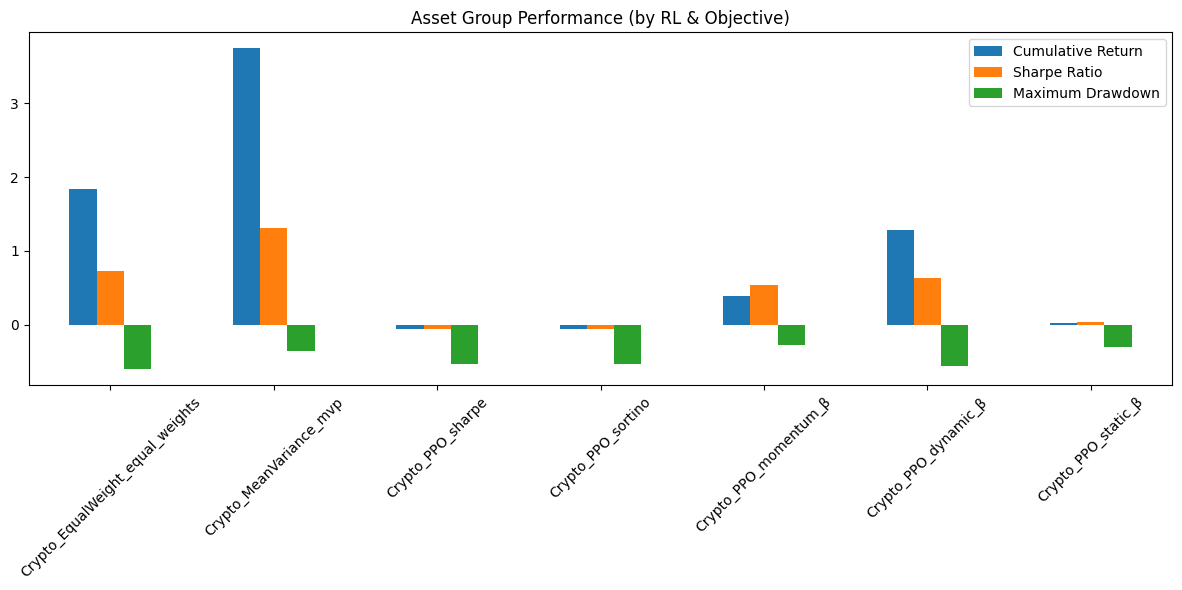

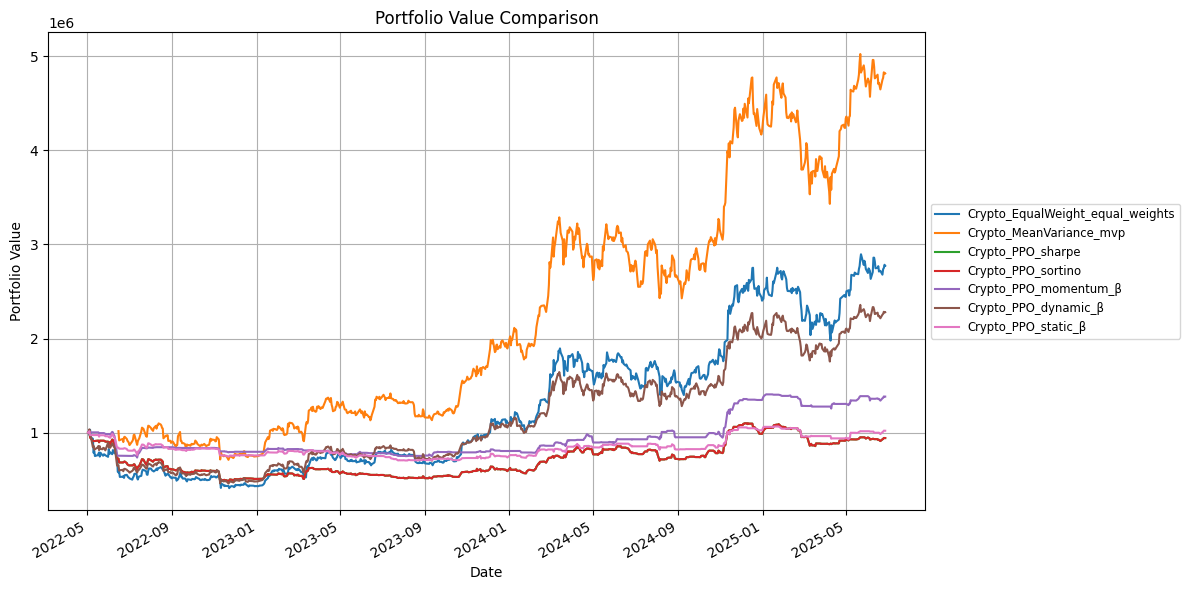

In [ ]:
 # 실험 실행
results = {}
previous_group = None

for group, assets, algo_name, algo_class, objective in Crypto_experiments:
    key = f"{group}_{algo_name}_{objective}"
    print(f"▶ Running: {key}")
    try:
        results[key] = train_and_evaluate(assets, algo_class, objective)
    except Exception as e:
        print(f"Error in {key}: {str(e)}")
        results[key] = None
    # 그룹이 바뀔때만 기술통계 출력
    if previous_group != group:
        show_summary = True
        previous_group = group
    else:
        show_summary = False


# 성과 요약 (오류 제외)
valid_results = {k: v for k, v in results.items() if v is not None}
metrics_table = pd.DataFrame({k: performance_metrics(v) for k, v in valid_results.items()}).T
print(metrics_table)

# 성과 막대그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 포트폴리오 가치 시계열 그래프
results_df = pd.DataFrame(valid_results)
ax = results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
# 🔽 범례를 오른쪽 바깥에 배치
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# sharpe 를 baseline으로 하여 통계적으로 의미가 있는지 비교함
summary = []

for (group, assets, algo, model_cls, obj) in Crypto_experiments:
    if obj == "sharpe":
        continue  # baseline 제외

    base_key = f"{group}_{algo}_sharpe"
    compare_key = f"{group}_{algo}_{obj}"

    # Add check for None before calling compare_strategies
    if base_key in results and compare_key in results and results[base_key] is not None and results[compare_key] is not None:
        res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
        summary.append({
            "Group": group,
            "Algorithm": algo,
            "CompareWith": obj,
            "t_p": res["t_p"],
            "u_p": res["u_p"]
        })

summary_df = pd.DataFrame(summary)
#import ace_tools as tools; tools.display_dataframe_to_user(name="Comparison Results", dataframe=summary_df)
print(summary_df)


🔎 [Crypto_PPO_sharpe vs Crypto_PPO_sortino]
▶ t-test p-value: 1.0000 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 1.0000 → 유의미하지 않음

🔎 [Crypto_PPO_sharpe vs Crypto_PPO_momentum_β]
▶ t-test p-value: 0.6519 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.0020 → 유의미함

🔎 [Crypto_PPO_sharpe vs Crypto_PPO_dynamic_β]
▶ t-test p-value: 0.2809 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.6430 → 유의미하지 않음

🔎 [Crypto_PPO_sharpe vs Crypto_PPO_static_β]
▶ t-test p-value: 0.9841 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.2847 → 유의미하지 않음
    Group Algorithm CompareWith       t_p       u_p
0  Crypto       PPO     sortino  1.000000  1.000000
1  Crypto       PPO  momentum_β  0.651891  0.001993
2  Crypto       PPO   dynamic_β  0.280891  0.643028
3  Crypto       PPO    static_β  0.984090  0.284743


In [ ]:
summary = []

for (group, assets, algo, model_cls, obj) in Crypto_experiments:
    if obj == "equal_weights":
        continue

    base_key = f"{group}_EqualWeight_equal_weights"  # EqualWeight로 고정
    compare_key = f"{group}_{algo}_{obj}"


    print(">> base:", base_key, "| compare:", compare_key)

    if base_key in results and compare_key in results:
        if results[base_key] is not None and results[compare_key] is not None:
            res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
            summary.append({
                "Group": group,
                "Algorithm": algo,
                "CompareWith": obj,
                "t_p": res["t_p"],
                "u_p": res["u_p"]
            })

        else:
            print(">> One of the results is None")
    else:
        print(">> Key missing in results")

summary_df = pd.DataFrame(summary)
print(summary_df)


>> base: Crypto_EqualWeight_equal_weights | compare: Crypto_MeanVariance_mvp

🔎 [Crypto_EqualWeight_equal_weights vs Crypto_MeanVariance_mvp]
▶ t-test p-value: 0.9904 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.9831 → 유의미하지 않음
>> base: Crypto_EqualWeight_equal_weights | compare: Crypto_PPO_sharpe

🔎 [Crypto_EqualWeight_equal_weights vs Crypto_PPO_sharpe]
▶ t-test p-value: 0.1969 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.5891 → 유의미하지 않음
>> base: Crypto_EqualWeight_equal_weights | compare: Crypto_PPO_sortino

🔎 [Crypto_EqualWeight_equal_weights vs Crypto_PPO_sortino]
▶ t-test p-value: 0.1969 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.5891 → 유의미하지 않음
>> base: Crypto_EqualWeight_equal_weights | compare: Crypto_PPO_momentum_β

🔎 [Crypto_EqualWeight_equal_weights vs Crypto_PPO_momentum_β]
▶ t-test p-value: 0.2753 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.8944 → 유의미하지 않음
>> base: Crypto_EqualWeight_equal_weights | compare: Crypto_PPO_dynamic_β

🔎 [Crypto_EqualWeight_equal_weights vs Cryp

# Crpyto asset all

▶ Running: Crypto_EqualWeight_equal_weights

[Train period: 2020-05-26 ~ 2023-12-13] (896 trading days, 70.0%)
[Test period: 2023-12-14 ~ 2025-06-27] (384 trading days, 30.0%)

[Train Summary: Price]
         count        mean         std        min         25%         50%  \
Ticker                                                                      
BNB-USD  896.0    273.1778    156.0762    15.4136    216.0126    283.8050   
BTC-USD  896.0  31029.4805  14238.0326  8835.0527  19982.9111  29004.0146   
ETH-USD  896.0   1881.2710   1044.5378   201.9023   1278.7502   1788.6684   
SOL-USD  896.0     46.0407     54.0413     0.5647     13.9544     25.1211   

                75%         max  
Ticker                           
BNB-USD    362.1731    675.6841  
BTC-USD  41149.6299  67566.8281  
ETH-USD   2467.2286   4812.0874  
SOL-USD     45.3623    248.4672  

[Test Summary: Price]
         count        mean         std         min         25%         50%  \
Ticker                          

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Crypto_PPO_sortino

[Train period: 2020-05-26 ~ 2023-12-13] (896 trading days, 70.0%)
[Test period: 2023-12-14 ~ 2025-06-27] (384 trading days, 30.0%)

[Train Summary: Price]
         count        mean         std        min         25%         50%  \
Ticker                                                                      
BNB-USD  896.0    273.1778    156.0762    15.4136    216.0126    283.8050   
BTC-USD  896.0  31029.4805  14238.0326  8835.0527  19982.9111  29004.0146   
ETH-USD  896.0   1881.2710   1044.5378   201.9023   1278.7502   1788.6684   
SOL-USD  896.0     46.0407     54.0413     0.5647     13.9544     25.1211   

                75%         max  
Ticker                           
BNB-USD    362.1731    675.6841  
BTC-USD  41149.6299  67566.8281  
ETH-USD   2467.2286   4812.0874  
SOL-USD     45.3623    248.4672  

[Test Summary: Price]
         count        mean         std         min         25%         50%  \
Ticker                               

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Crypto_PPO_momentum_β

[Train period: 2020-05-26 ~ 2023-12-13] (896 trading days, 70.0%)
[Test period: 2023-12-14 ~ 2025-06-27] (384 trading days, 30.0%)

[Train Summary: Price]
         count        mean         std        min         25%         50%  \
Ticker                                                                      
BNB-USD  896.0    273.1778    156.0762    15.4136    216.0126    283.8050   
BTC-USD  896.0  31029.4805  14238.0326  8835.0527  19982.9111  29004.0146   
ETH-USD  896.0   1881.2710   1044.5378   201.9023   1278.7502   1788.6684   
SOL-USD  896.0     46.0407     54.0413     0.5647     13.9544     25.1211   

                75%         max  
Ticker                           
BNB-USD    362.1731    675.6841  
BTC-USD  41149.6299  67566.8281  
ETH-USD   2467.2286   4812.0874  
SOL-USD     45.3623    248.4672  

[Test Summary: Price]
         count        mean         std         min         25%         50%  \
Ticker                            

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Crypto_PPO_dynamic_β

[Train period: 2020-05-26 ~ 2023-12-13] (896 trading days, 70.0%)
[Test period: 2023-12-14 ~ 2025-06-27] (384 trading days, 30.0%)

[Train Summary: Price]
         count        mean         std        min         25%         50%  \
Ticker                                                                      
BNB-USD  896.0    273.1778    156.0762    15.4136    216.0126    283.8050   
BTC-USD  896.0  31029.4805  14238.0326  8835.0527  19982.9111  29004.0146   
ETH-USD  896.0   1881.2710   1044.5378   201.9023   1278.7502   1788.6684   
SOL-USD  896.0     46.0407     54.0413     0.5647     13.9544     25.1211   

                75%         max  
Ticker                           
BNB-USD    362.1731    675.6841  
BTC-USD  41149.6299  67566.8281  
ETH-USD   2467.2286   4812.0874  
SOL-USD     45.3623    248.4672  

[Test Summary: Price]
         count        mean         std         min         25%         50%  \
Ticker                             

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Crypto_PPO_static_β

[Train period: 2020-05-26 ~ 2023-12-13] (896 trading days, 70.0%)
[Test period: 2023-12-14 ~ 2025-06-27] (384 trading days, 30.0%)

[Train Summary: Price]
         count        mean         std        min         25%         50%  \
Ticker                                                                      
BNB-USD  896.0    273.1778    156.0762    15.4136    216.0126    283.8050   
BTC-USD  896.0  31029.4805  14238.0326  8835.0527  19982.9111  29004.0146   
ETH-USD  896.0   1881.2710   1044.5378   201.9023   1278.7502   1788.6684   
SOL-USD  896.0     46.0407     54.0413     0.5647     13.9544     25.1211   

                75%         max  
Ticker                           
BNB-USD    362.1731    675.6841  
BTC-USD  41149.6299  67566.8281  
ETH-USD   2467.2286   4812.0874  
SOL-USD     45.3623    248.4672  

[Test Summary: Price]
         count        mean         std         min         25%         50%  \
Ticker                              

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
                                  Sharpe Ratio  Sortino Ratio  \
Crypto_EqualWeight_equal_weights      1.112386       1.722550   
Crypto_MeanVariance_mvp               1.093927       1.743104   
Crypto_PPO_sharpe                     0.678635       0.933709   
Crypto_PPO_sortino                    0.667442       0.948260   
Crypto_PPO_momentum_β                 0.953884       1.459038   
Crypto_PPO_dynamic_β                  0.658626       0.966984   
Crypto_PPO_static_β                   0.667442       0.948260   

                                  Cumulative Return  Annualized Return  \
Crypto_EqualWeight_equal_weights           1.099233           0.631018   
Crypto_MeanVariance_mvp                    0.892988           0.577069   
Crypto_PPO_sharpe                          0.257752           0.162410   
Crypto_PPO_sortino                         0.358234           0.222544   
Crypto_PPO_momentum_β                      0.533369           0.323825   
Crypto_PPO_dynamic_β      

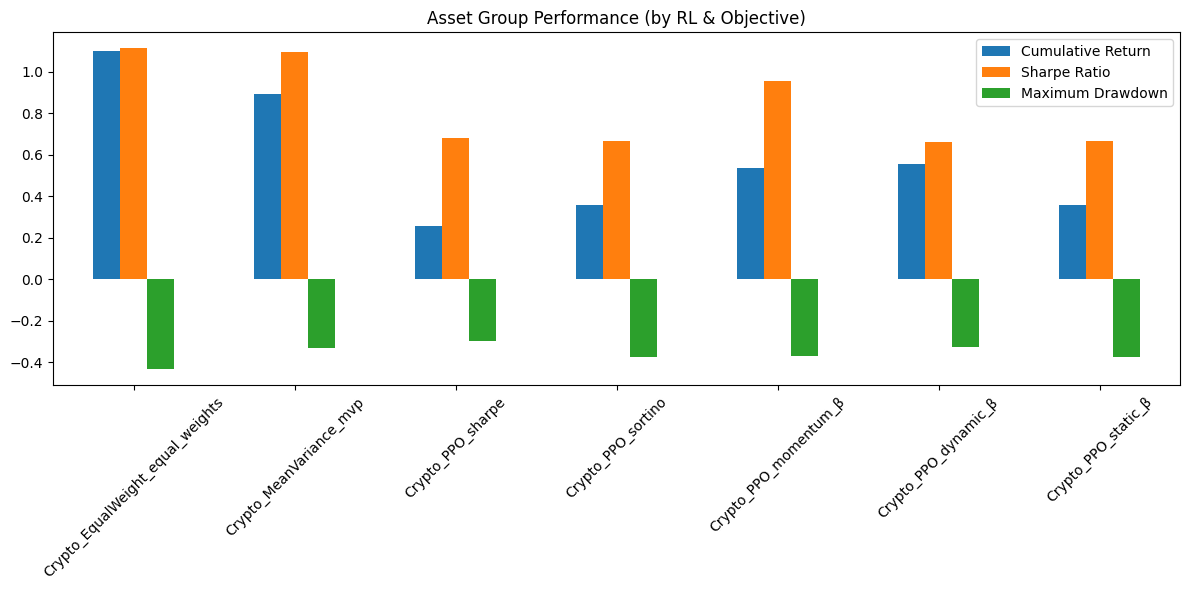

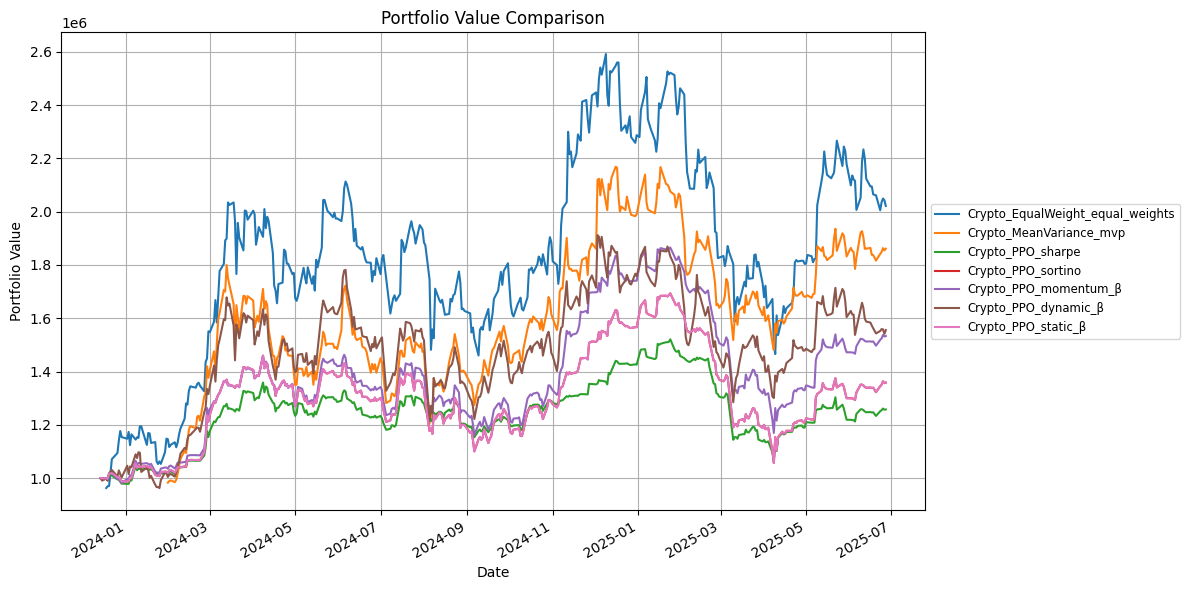

In [ ]:
# 실험 실행
results = {}
previous_group = None

for group, assets, algo_name, algo_class, objective in Crypto_experiments_old:
    key = f"{group}_{algo_name}_{objective}"
    print(f"▶ Running: {key}")
    try:
        results[key] = train_and_evaluate(assets, algo_class, objective)
    except Exception as e:
        print(f"Error in {key}: {str(e)}")
        results[key] = None
    # 그룹이 바뀔때만 기술통계 출력
    if previous_group != group:
        show_summary = True
        previous_group = group
    else:
        show_summary = False


# 성과 요약 (오류 제외)
valid_results = {k: v for k, v in results.items() if v is not None}
metrics_table = pd.DataFrame({k: performance_metrics(v) for k, v in valid_results.items()}).T
print(metrics_table)

# 성과 막대그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 포트폴리오 가치 시계열 그래프
results_df = pd.DataFrame(valid_results)
ax = results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
# 🔽 범례를 오른쪽 바깥에 배치
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small')
plt.tight_layout()

In [ ]:
# sharpe 를 baseline으로 하여 통계적으로 의미가 있는지 비교함
summary = []

for (group, assets, algo, model_cls, obj) in Crypto_experiments_old:
    if obj == "sharpe":
        continue  # baseline 제외

    base_key = f"{group}_{algo}_sharpe"
    compare_key = f"{group}_{algo}_{obj}"

    # Add check for None before calling compare_strategies
    if base_key in results and compare_key in results and results[base_key] is not None and results[compare_key] is not None:
        res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
        summary.append({
            "Group": group,
            "Algorithm": algo,
            "CompareWith": obj,
            "t_p": res["t_p"],
            "u_p": res["u_p"]
        })

summary_df = pd.DataFrame(summary)
#import ace_tools as tools; tools.display_dataframe_to_user(name="Comparison Results", dataframe=summary_df)
print(summary_df)


🔎 [Crypto_PPO_sharpe vs Crypto_PPO_sortino]
▶ t-test p-value: 0.8165 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.9693 → 유의미하지 않음

🔎 [Crypto_PPO_sharpe vs Crypto_PPO_momentum_β]
▶ t-test p-value: 0.6375 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.9828 → 유의미하지 않음

🔎 [Crypto_PPO_sharpe vs Crypto_PPO_dynamic_β]
▶ t-test p-value: 0.5976 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.7214 → 유의미하지 않음

🔎 [Crypto_PPO_sharpe vs Crypto_PPO_static_β]
▶ t-test p-value: 0.8165 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.9693 → 유의미하지 않음
    Group Algorithm CompareWith       t_p       u_p
0  Crypto       PPO     sortino  0.816507  0.969260
1  Crypto       PPO  momentum_β  0.637468  0.982803
2  Crypto       PPO   dynamic_β  0.597616  0.721369
3  Crypto       PPO    static_β  0.816507  0.969260


In [ ]:
summary = []

for (group, assets, algo, model_cls, obj) in Crypto_experiments_old:
    if obj == "equal_weights":
        continue

    base_key = f"{group}_EqualWeight_equal_weights"  # EqualWeight로 고정
    compare_key = f"{group}_{algo}_{obj}"


    print(">> base:", base_key, "| compare:", compare_key)

    if base_key in results and compare_key in results:
        if results[base_key] is not None and results[compare_key] is not None:
            res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
            summary.append({
                "Group": group,
                "Algorithm": algo,
                "CompareWith": obj,
                "t_p": res["t_p"],
                "u_p": res["u_p"]
            })

        else:
            print(">> One of the results is None")
    else:
        print(">> Key missing in results")

summary_df = pd.DataFrame(summary)
print(summary_df)

>> base: Crypto_EqualWeight_equal_weights | compare: Crypto_MeanVariance_mvp

🔎 [Crypto_EqualWeight_equal_weights vs Crypto_MeanVariance_mvp]
▶ t-test p-value: 0.9695 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.9981 → 유의미하지 않음
>> base: Crypto_EqualWeight_equal_weights | compare: Crypto_PPO_sharpe

🔎 [Crypto_EqualWeight_equal_weights vs Crypto_PPO_sharpe]
▶ t-test p-value: 0.3482 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.6551 → 유의미하지 않음
>> base: Crypto_EqualWeight_equal_weights | compare: Crypto_PPO_sortino

🔎 [Crypto_EqualWeight_equal_weights vs Crypto_PPO_sortino]
▶ t-test p-value: 0.4638 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.6726 → 유의미하지 않음
>> base: Crypto_EqualWeight_equal_weights | compare: Crypto_PPO_momentum_β

🔎 [Crypto_EqualWeight_equal_weights vs Crypto_PPO_momentum_β]
▶ t-test p-value: 0.5640 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.6795 → 유의미하지 않음
>> base: Crypto_EqualWeight_equal_weights | compare: Crypto_PPO_dynamic_β

🔎 [Crypto_EqualWeight_equal_weights vs Cryp

# Macro asset

▶ Running: Macro_EqualWeight_equal_weights

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
         count      mean      std       min       25%       50%       75%  \
Ticker                                                                      
GLD     1845.0  135.7762  24.3751  100.5000  117.2900  124.3600  162.3500   
IEF     1845.0   94.1352   7.6994   83.7359   87.4014   90.7012  101.7175   
SLV     1845.0   17.3515   3.5519   11.2100   14.8800   16.0500   19.1000   
TIP     1845.0   94.3801   8.7273   83.3248   88.2454   89.7123  102.3400   
TLT     1845.0  110.8825  15.8319   88.2493   98.4754  103.1778  123.1514   

             max  
Ticker            
GLD     193.8900  
IEF     109.4531  
SLV      27.0000  
TIP     113.4396  
TLT     148.6343  

[Test Summary: Price]
        count      mean      std       min       25%       50%       75%  \
Ticker                      

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Macro_PPO_sortino

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
         count      mean      std       min       25%       50%       75%  \
Ticker                                                                      
GLD     1845.0  135.7762  24.3751  100.5000  117.2900  124.3600  162.3500   
IEF     1845.0   94.1352   7.6994   83.7359   87.4014   90.7012  101.7175   
SLV     1845.0   17.3515   3.5519   11.2100   14.8800   16.0500   19.1000   
TIP     1845.0   94.3801   8.7273   83.3248   88.2454   89.7123  102.3400   
TLT     1845.0  110.8825  15.8319   88.2493   98.4754  103.1778  123.1514   

             max  
Ticker            
GLD     193.8900  
IEF     109.4531  
SLV      27.0000  
TIP     113.4396  
TLT     148.6343  

[Test Summary: Price]
        count      mean      std       min       25%       50%       75%  \
Ticker                           

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Macro_PPO_momentum_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
         count      mean      std       min       25%       50%       75%  \
Ticker                                                                      
GLD     1845.0  135.7762  24.3751  100.5000  117.2900  124.3600  162.3500   
IEF     1845.0   94.1352   7.6994   83.7359   87.4014   90.7012  101.7175   
SLV     1845.0   17.3515   3.5519   11.2100   14.8800   16.0500   19.1000   
TIP     1845.0   94.3801   8.7273   83.3248   88.2454   89.7123  102.3400   
TLT     1845.0  110.8825  15.8319   88.2493   98.4754  103.1778  123.1514   

             max  
Ticker            
GLD     193.8900  
IEF     109.4531  
SLV      27.0000  
TIP     113.4396  
TLT     148.6343  

[Test Summary: Price]
        count      mean      std       min       25%       50%       75%  \
Ticker                        

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Macro_PPO_dynamic_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
         count      mean      std       min       25%       50%       75%  \
Ticker                                                                      
GLD     1845.0  135.7762  24.3751  100.5000  117.2900  124.3600  162.3500   
IEF     1845.0   94.1352   7.6994   83.7359   87.4014   90.7012  101.7175   
SLV     1845.0   17.3515   3.5519   11.2100   14.8800   16.0500   19.1000   
TIP     1845.0   94.3801   8.7273   83.3248   88.2454   89.7123  102.3400   
TLT     1845.0  110.8825  15.8319   88.2493   98.4754  103.1778  123.1514   

             max  
Ticker            
GLD     193.8900  
IEF     109.4531  
SLV      27.0000  
TIP     113.4396  
TLT     148.6343  

[Test Summary: Price]
        count      mean      std       min       25%       50%       75%  \
Ticker                         

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Macro_PPO_static_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
         count      mean      std       min       25%       50%       75%  \
Ticker                                                                      
GLD     1845.0  135.7762  24.3751  100.5000  117.2900  124.3600  162.3500   
IEF     1845.0   94.1352   7.6994   83.7359   87.4014   90.7012  101.7175   
SLV     1845.0   17.3515   3.5519   11.2100   14.8800   16.0500   19.1000   
TIP     1845.0   94.3801   8.7273   83.3248   88.2454   89.7123  102.3400   
TLT     1845.0  110.8825  15.8319   88.2493   98.4754  103.1778  123.1514   

             max  
Ticker            
GLD     193.8900  
IEF     109.4531  
SLV      27.0000  
TIP     113.4396  
TLT     148.6343  

[Test Summary: Price]
        count      mean      std       min       25%       50%       75%  \
Ticker                          

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
                                 Sharpe Ratio  Sortino Ratio  \
Macro_EqualWeight_equal_weights      0.570333       0.972252   
Macro_MeanVariance_mvp               0.190350       0.304190   
Macro_PPO_sharpe                     1.029464       1.370123   
Macro_PPO_sortino                    1.039337       1.377278   
Macro_PPO_momentum_β                 1.243591       1.661291   
Macro_PPO_dynamic_β                  0.724966       1.155997   
Macro_PPO_static_β                   1.148149       1.533451   

                                 Cumulative Return  Annualized Return  \
Macro_EqualWeight_equal_weights           0.225518           0.067021   
Macro_MeanVariance_mvp                    0.038810           0.012688   
Macro_PPO_sharpe                          0.045907           0.014384   
Macro_PPO_sortino                         0.053033           0.016578   
Macro_PPO_momentum_β                      0.362815           0.103508   
Macro_PPO_dynamic_β                     

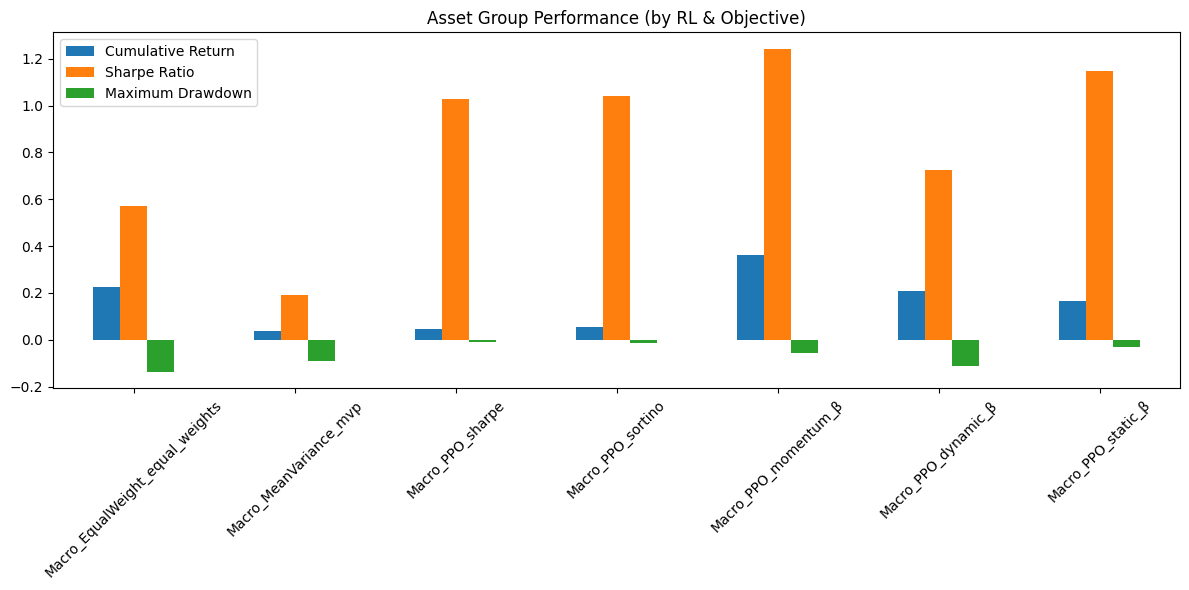

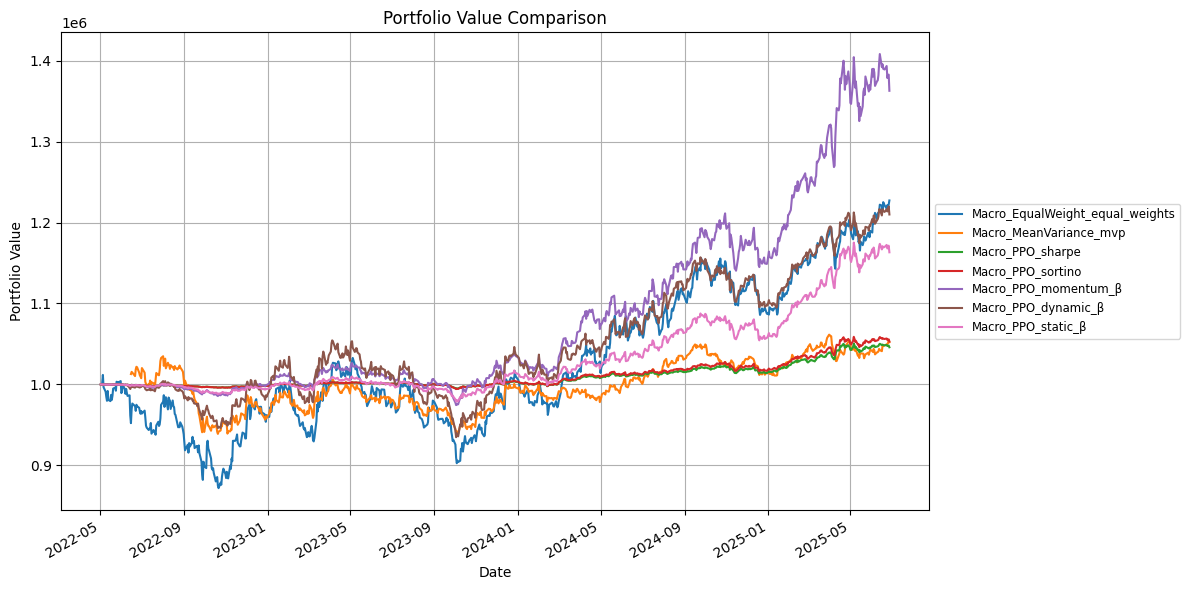

In [ ]:
 # 실험 실행
results = {}
previous_group = None

for group, assets, algo_name, algo_class, objective in Macro_experiments:
    key = f"{group}_{algo_name}_{objective}"
    print(f"▶ Running: {key}")
    try:
        results[key] = train_and_evaluate(assets, algo_class, objective)
    except Exception as e:
        print(f"Error in {key}: {str(e)}")
        results[key] = None
    # 그룹이 바뀔때만 기술통계 출력
    if previous_group != group:
        show_summary = True
        previous_group = group
    else:
        show_summary = False


# 성과 요약 (오류 제외)
valid_results = {k: v for k, v in results.items() if v is not None}
metrics_table = pd.DataFrame({k: performance_metrics(v) for k, v in valid_results.items()}).T
print(metrics_table)

# 성과 막대그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 포트폴리오 가치 시계열 그래프
results_df = pd.DataFrame(valid_results)
ax = results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
# 🔽 범례를 오른쪽 바깥에 배치
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small')
plt.tight_layout()
plt.show()

In [ ]:
# sharpe 를 baseline으로 하여 통계적으로 의미가 있는지 비교함
summary = []

for (group, assets, algo, model_cls, obj) in Macro_experiments:
    if obj == "sharpe":
        continue  # baseline 제외

    base_key = f"{group}_{algo}_sharpe"
    compare_key = f"{group}_{algo}_{obj}"

    # Add check for None before calling compare_strategies
    if base_key in results and compare_key in results and results[base_key] is not None and results[compare_key] is not None:
        res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
        summary.append({
            "Group": group,
            "Algorithm": algo,
            "CompareWith": obj,
            "t_p": res["t_p"],
            "u_p": res["u_p"]
        })

summary_df = pd.DataFrame(summary)
#import ace_tools as tools; tools.display_dataframe_to_user(name="Comparison Results", dataframe=summary_df)
print(summary_df)


🔎 [Macro_PPO_sharpe vs Macro_PPO_sortino]
▶ t-test p-value: 0.8546 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.9311 → 유의미하지 않음

🔎 [Macro_PPO_sharpe vs Macro_PPO_momentum_β]
▶ t-test p-value: 0.0660 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.3645 → 유의미하지 않음

🔎 [Macro_PPO_sharpe vs Macro_PPO_dynamic_β]
▶ t-test p-value: 0.3105 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.7131 → 유의미하지 않음

🔎 [Macro_PPO_sharpe vs Macro_PPO_static_β]
▶ t-test p-value: 0.1735 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.5035 → 유의미하지 않음
   Group Algorithm CompareWith       t_p       u_p
0  Macro       PPO     sortino  0.854630  0.931144
1  Macro       PPO  momentum_β  0.065975  0.364530
2  Macro       PPO   dynamic_β  0.310452  0.713143
3  Macro       PPO    static_β  0.173544  0.503487


In [ ]:
summary = []

for (group, assets, algo, model_cls, obj) in Macro_experiments:
    if obj == "equal_weights":
        continue

    base_key = f"{group}_EqualWeight_equal_weights"  # EqualWeight로 고정
    compare_key = f"{group}_{algo}_{obj}"


    print(">> base:", base_key, "| compare:", compare_key)

    if base_key in results and compare_key in results:
        if results[base_key] is not None and results[compare_key] is not None:
            res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
            summary.append({
                "Group": group,
                "Algorithm": algo,
                "CompareWith": obj,
                "t_p": res["t_p"],
                "u_p": res["u_p"]
            })

        else:
            print(">> One of the results is None")
    else:
        print(">> Key missing in results")

summary_df = pd.DataFrame(summary)
print(summary_df)


>> base: Macro_EqualWeight_equal_weights | compare: Macro_MeanVariance_mvp

🔎 [Macro_EqualWeight_equal_weights vs Macro_MeanVariance_mvp]
▶ t-test p-value: 0.3250 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.5812 → 유의미하지 않음
>> base: Macro_EqualWeight_equal_weights | compare: Macro_PPO_sharpe

🔎 [Macro_EqualWeight_equal_weights vs Macro_PPO_sharpe]
▶ t-test p-value: 0.3909 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.9535 → 유의미하지 않음
>> base: Macro_EqualWeight_equal_weights | compare: Macro_PPO_sortino

🔎 [Macro_EqualWeight_equal_weights vs Macro_PPO_sortino]
▶ t-test p-value: 0.4102 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.9323 → 유의미하지 않음
>> base: Macro_EqualWeight_equal_weights | compare: Macro_PPO_momentum_β

🔎 [Macro_EqualWeight_equal_weights vs Macro_PPO_momentum_β]
▶ t-test p-value: 0.7080 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.3451 → 유의미하지 않음
>> base: Macro_EqualWeight_equal_weights | compare: Macro_PPO_dynamic_β

🔎 [Macro_EqualWeight_equal_weights vs Macro_PPO_dynamic_β]
▶ 

# Multi asset

▶ Running: Multi_EqualWeight_equal_weights

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3646   216.8292   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0002   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014 

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_PPO_sortino

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3646   216.8292   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0002   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014    90

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_PPO_momentum_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3646   216.8292   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0002   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014   

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_PPO_dynamic_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3646   216.8292   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0002   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014    

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_PPO_static_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3646   216.8292   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0002   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014    9

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
                                 Sharpe Ratio  Sortino Ratio  \
Multi_EqualWeight_equal_weights      1.126334       1.542742   
Multi_MeanVariance_mvp               0.352336       0.529140   
Multi_PPO_sharpe                     0.057351       0.057902   
Multi_PPO_sortino                    0.149590       0.151721   
Multi_PPO_momentum_β                 0.172236       0.177178   
Multi_PPO_dynamic_β                  0.555975       0.589411   
Multi_PPO_static_β                   0.295379       0.293620   

                                 Cumulative Return  Annualized Return  \
Multi_EqualWeight_equal_weights           0.732002           0.191500   
Multi_MeanVariance_mvp                    0.076190           0.024613   
Multi_PPO_sharpe                          0.039298           0.012340   
Multi_PPO_sortino                         0.106250           0.032650   
Multi_PPO_momentum_β                      0.128344           0.039168   
Multi_PPO_dynamic_β                     

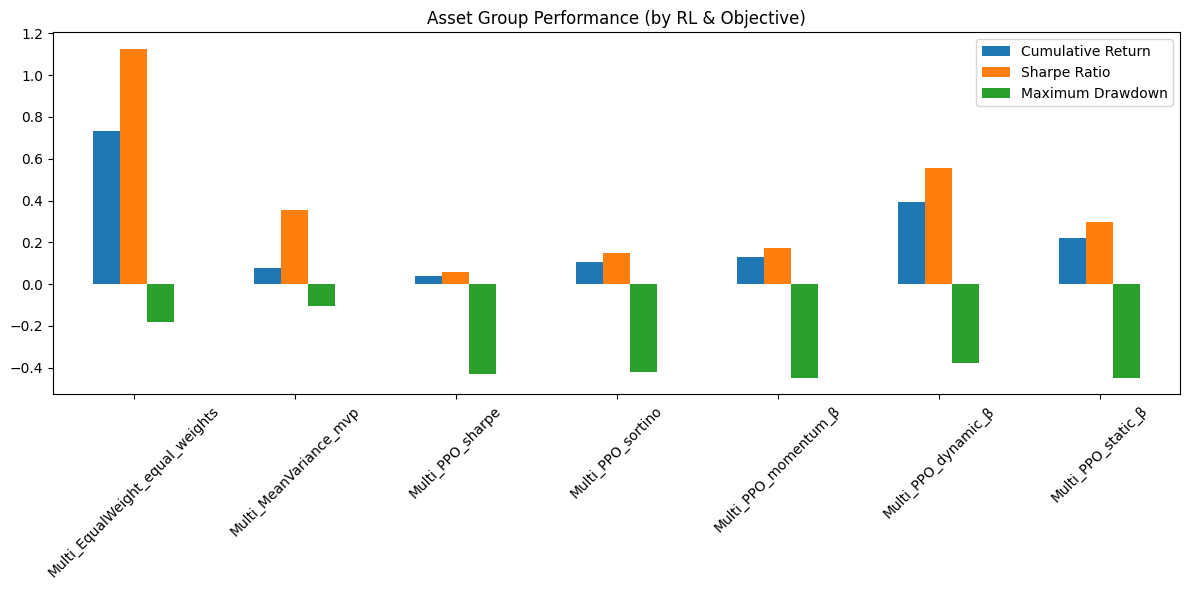

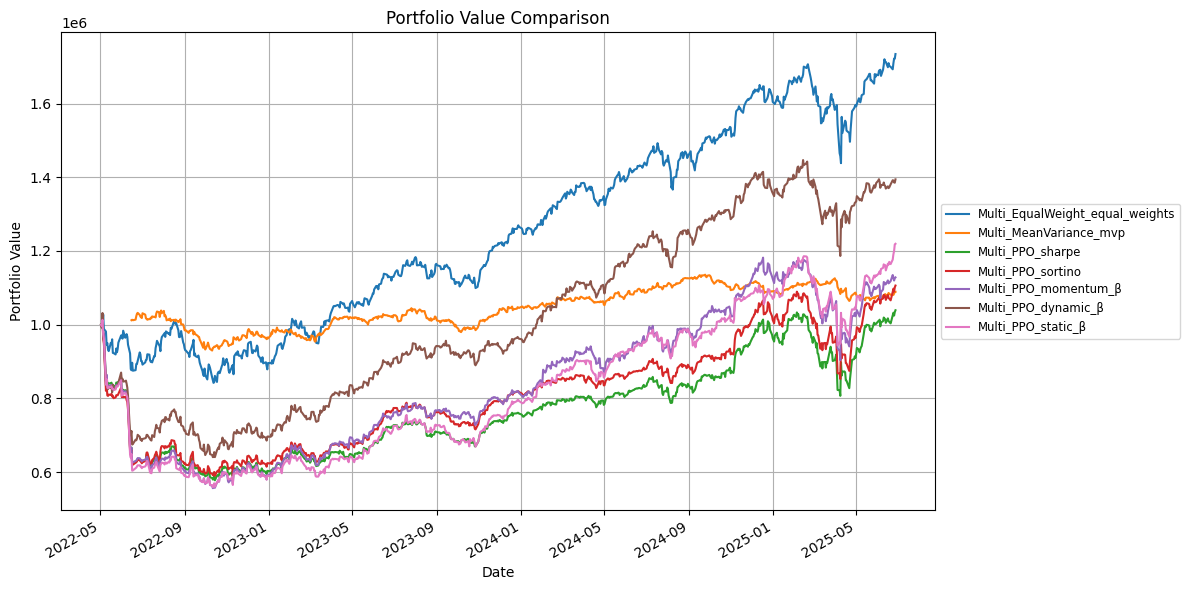


🔎 [Multi_PPO_sharpe vs Multi_PPO_sortino]
▶ t-test p-value: 0.9055 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.8671 → 유의미하지 않음

🔎 [Multi_PPO_sharpe vs Multi_PPO_momentum_β]
▶ t-test p-value: 0.8698 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.6892 → 유의미하지 않음

🔎 [Multi_PPO_sharpe vs Multi_PPO_dynamic_β]
▶ t-test p-value: 0.5861 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.5762 → 유의미하지 않음

🔎 [Multi_PPO_sharpe vs Multi_PPO_static_β]
▶ t-test p-value: 0.7634 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.6293 → 유의미하지 않음
   Group Algorithm CompareWith       t_p       u_p
0  Multi       PPO     sortino  0.905486  0.867128
1  Multi       PPO  momentum_β  0.869774  0.689157
2  Multi       PPO   dynamic_β  0.586115  0.576202
3  Multi       PPO    static_β  0.763412  0.629257


In [ ]:
 # 실험 실행
results = {}
previous_group = None

for group, assets, algo_name, algo_class, objective in Multi_experiments:
    key = f"{group}_{algo_name}_{objective}"
    print(f"▶ Running: {key}")
    try:
        results[key] = train_and_evaluate(assets, algo_class, objective)
    except Exception as e:
        print(f"Error in {key}: {str(e)}")
        results[key] = None
    # 그룹이 바뀔때만 기술통계 출력
    if previous_group != group:
        show_summary = True
        previous_group = group
    else:
        show_summary = False


# 성과 요약 (오류 제외)
valid_results = {k: v for k, v in results.items() if v is not None}
metrics_table = pd.DataFrame({k: performance_metrics(v) for k, v in valid_results.items()}).T
print(metrics_table)

# 성과 막대그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# 포트폴리오 가치 시계열 그래프
results_df = pd.DataFrame(valid_results)
ax = results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
# 🔽 범례를 오른쪽 바깥에 배치
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small')
plt.tight_layout()
plt.show()


# sharpe 를 baseline으로 하여 통계적으로 의미가 있는지 비교함
summary = []

for (group, assets, algo, model_cls, obj) in Multi_experiments:
    if obj == "sharpe":
        continue  # baseline 제외

    base_key = f"{group}_{algo}_sharpe"
    compare_key = f"{group}_{algo}_{obj}"

    # Add check for None before calling compare_strategies
    if base_key in results and compare_key in results and results[base_key] is not None and results[compare_key] is not None:
        res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
        summary.append({
            "Group": group,
            "Algorithm": algo,
            "CompareWith": obj,
            "t_p": res["t_p"],
            "u_p": res["u_p"]
        })

summary_df = pd.DataFrame(summary)
#import ace_tools as tools; tools.display_dataframe_to_user(name="Comparison Results", dataframe=summary_df)
print(summary_df)

In [ ]:
summary = []

for (group, assets, algo, model_cls, obj) in Multi_experiments:
    if obj == "equal_weights":
        continue

    base_key = f"{group}_EqualWeight_equal_weights"  # EqualWeight로 고정
    compare_key = f"{group}_{algo}_{obj}"


    print(">> base:", base_key, "| compare:", compare_key)

    if base_key in results and compare_key in results:
        if results[base_key] is not None and results[compare_key] is not None:
            res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
            summary.append({
                "Group": group,
                "Algorithm": algo,
                "CompareWith": obj,
                "t_p": res["t_p"],
                "u_p": res["u_p"]
            })

        else:
            print(">> One of the results is None")
    else:
        print(">> Key missing in results")

summary_df = pd.DataFrame(summary)
print(summary_df)


>> base: Multi_EqualWeight_equal_weights | compare: Multi_MeanVariance_mvp

🔎 [Multi_EqualWeight_equal_weights vs Multi_MeanVariance_mvp]
▶ t-test p-value: 0.0360 → 유의미함
▶ Mann–Whitney U-test p-value: 0.0045 → 유의미함
>> base: Multi_EqualWeight_equal_weights | compare: Multi_PPO_sharpe

🔎 [Multi_EqualWeight_equal_weights vs Multi_PPO_sharpe]
▶ t-test p-value: 0.3082 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.5546 → 유의미하지 않음
>> base: Multi_EqualWeight_equal_weights | compare: Multi_PPO_sortino

🔎 [Multi_EqualWeight_equal_weights vs Multi_PPO_sortino]
▶ t-test p-value: 0.3740 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.6640 → 유의미하지 않음
>> base: Multi_EqualWeight_equal_weights | compare: Multi_PPO_momentum_β

🔎 [Multi_EqualWeight_equal_weights vs Multi_PPO_momentum_β]
▶ t-test p-value: 0.4277 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.8729 → 유의미하지 않음
>> base: Multi_EqualWeight_equal_weights | compare: Multi_PPO_dynamic_β

🔎 [Multi_EqualWeight_equal_weights vs Multi_PPO_dynamic_β]
▶ t-test p

## Multi Asset SAC

▶ Running: Multi_EqualWeight_equal_weights

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3647   216.8293   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0002   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014 

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_SAC_sortino

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3647   216.8293   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0002   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014    90

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_SAC_momentum_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3647   216.8293   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0002   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014   

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_SAC_dynamic_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3647   216.8293   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0002   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014    

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_SAC_static_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3647   216.8293   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0002   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014    9

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
                                 Sharpe Ratio  Sortino Ratio  \
Multi_EqualWeight_equal_weights      1.126334       1.542742   
Multi_MeanVariance_mvp               0.352350       0.529158   
Multi_SAC_sharpe                     0.869367       1.244937   
Multi_SAC_sortino                    0.938916       1.331648   
Multi_SAC_momentum_β                 0.157132       0.160747   
Multi_SAC_dynamic_β                  0.940727       1.254717   
Multi_SAC_static_β                   0.839937       1.192270   

                                 Cumulative Return  Annualized Return  \
Multi_EqualWeight_equal_weights           0.732002           0.191500   
Multi_MeanVariance_mvp                    0.076193           0.024614   
Multi_SAC_sharpe                          1.475357           0.334284   
Multi_SAC_sortino                         0.491953           0.135758   
Multi_SAC_momentum_β                      0.116464           0.035675   
Multi_SAC_dynamic_β                     

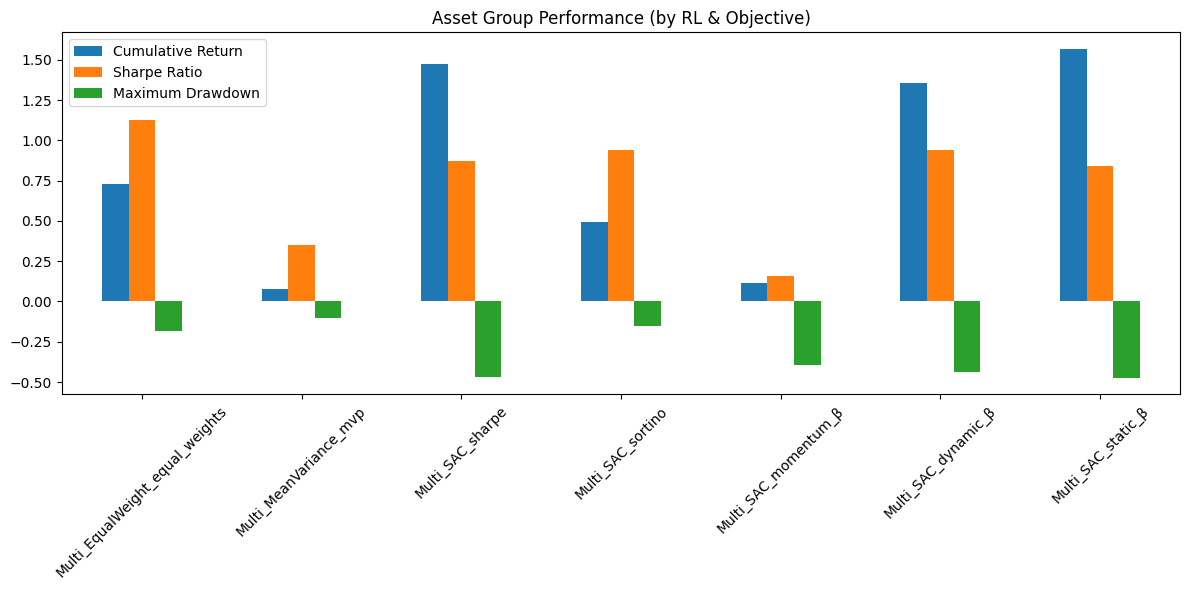

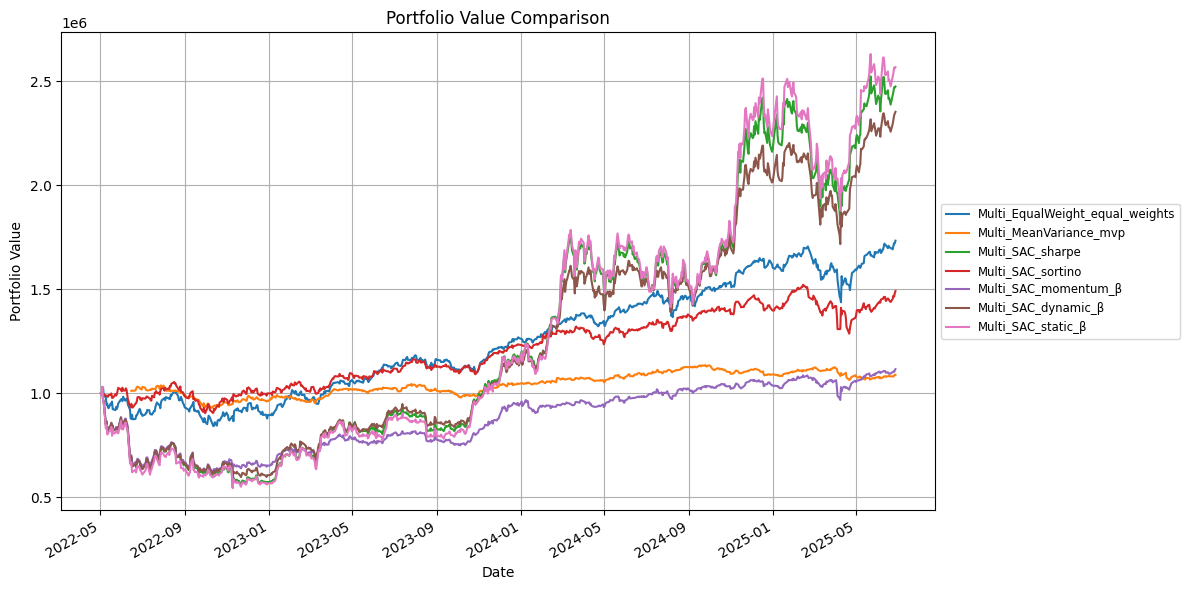

Empty DataFrame
Columns: []
Index: []


In [ ]:
 # 실험 실행
results = {}
previous_group = None

for group, assets, algo_name, algo_class, objective in Multi_all_experiments_sac:
    key = f"{group}_{algo_name}_{objective}"
    print(f"▶ Running: {key}")
    try:
        results[key] = train_and_evaluate(assets, algo_class, objective)
    except Exception as e:
        print(f"Error in {key}: {str(e)}")
        results[key] = None
    # 그룹이 바뀔때만 기술통계 출력
    if previous_group != group:
        show_summary = True
        previous_group = group
    else:
        show_summary = False


# 성과 요약 (오류 제외)
valid_results = {k: v for k, v in results.items() if v is not None}
metrics_table = pd.DataFrame({k: performance_metrics(v) for k, v in valid_results.items()}).T
print(metrics_table)

# 성과 막대그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# 포트폴리오 가치 시계열 그래프
results_df = pd.DataFrame(valid_results)
ax = results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
# 🔽 범례를 오른쪽 바깥에 배치
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small')
plt.tight_layout()
plt.show()


# sharpe 를 baseline으로 하여 통계적으로 의미가 있는지 비교함
summary = []

for (group, assets, algo, model_cls, obj) in Multi_experiments:
    if obj == "sharpe":
        continue  # baseline 제외

    base_key = f"{group}_{algo}_sharpe"
    compare_key = f"{group}_{algo}_{obj}"

    # Add check for None before calling compare_strategies
    if base_key in results and compare_key in results and results[base_key] is not None and results[compare_key] is not None:
        res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
        summary.append({
            "Group": group,
            "Algorithm": algo,
            "CompareWith": obj,
            "t_p": res["t_p"],
            "u_p": res["u_p"]
        })

summary_df = pd.DataFrame(summary)
#import ace_tools as tools; tools.display_dataframe_to_user(name="Comparison Results", dataframe=summary_df)
print(summary_df)

In [ ]:
summary = []

for (group, assets, algo, model_cls, obj) in Multi_all_experiments_sac:
    if obj == "equal_weights":
        continue

    base_key = f"{group}_EqualWeight_equal_weights"  # EqualWeight로 고정
    compare_key = f"{group}_{algo}_{obj}"


    print(">> base:", base_key, "| compare:", compare_key)

    if base_key in results and compare_key in results:
        if results[base_key] is not None and results[compare_key] is not None:
            res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
            summary.append({
                "Group": group,
                "Algorithm": algo,
                "CompareWith": obj,
                "t_p": res["t_p"],
                "u_p": res["u_p"]
            })

        else:
            print(">> One of the results is None")
    else:
        print(">> Key missing in results")

summary_df = pd.DataFrame(summary)
print(summary_df)

>> base: Multi_EqualWeight_equal_weights | compare: Multi_MeanVariance_mvp

🔎 [Multi_EqualWeight_equal_weights vs Multi_MeanVariance_mvp]
▶ t-test p-value: 0.0360 → 유의미함
▶ Mann–Whitney U-test p-value: 0.0045 → 유의미함
>> base: Multi_EqualWeight_equal_weights | compare: Multi_SAC_sharpe

🔎 [Multi_EqualWeight_equal_weights vs Multi_SAC_sharpe]
▶ t-test p-value: 0.4882 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.8493 → 유의미하지 않음
>> base: Multi_EqualWeight_equal_weights | compare: Multi_SAC_sortino

🔎 [Multi_EqualWeight_equal_weights vs Multi_SAC_sortino]
▶ t-test p-value: 0.6788 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.4171 → 유의미하지 않음
>> base: Multi_EqualWeight_equal_weights | compare: Multi_SAC_momentum_β

🔎 [Multi_EqualWeight_equal_weights vs Multi_SAC_momentum_β]
▶ t-test p-value: 0.3905 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.4583 → 유의미하지 않음
>> base: Multi_EqualWeight_equal_weights | compare: Multi_SAC_dynamic_β

🔎 [Multi_EqualWeight_equal_weights vs Multi_SAC_dynamic_β]
▶ t-test p

# Multi asset TD3

▶ Running: Multi_EqualWeight_equal_weights

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3647   216.8293   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0001   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014 

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_TD3_sortino

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3647   216.8293   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0001   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014    90

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_TD3_momentum_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3647   216.8293   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0001   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014   

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_TD3_dynamic_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3647   216.8293   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0001   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014    

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
▶ Running: Multi_TD3_static_β

[Train period: 2015-01-02 ~ 2022-04-29] (1845 trading days, 70.0%)
[Test period: 2022-05-02 ~ 2025-06-27] (792 trading days, 30.0%)

[Train Summary: Price]
          count        mean         std       min       25%        50%  \
Ticker                                                                   
AAPL     1845.0     63.5308     44.9641   20.6475   28.3542    43.2791   
AMZN     1845.0     86.0640     51.4040   14.3475   38.6220    82.8110   
BA       1845.0    222.0793     89.1122   95.0100  133.7385   208.3400   
BTC-USD  1845.0  12559.8895  16774.0070  178.1030  704.3760  6639.1401   
DIA      1845.0    218.4911     60.9017  127.9686  155.3647   216.8293   
DIS      1845.0    118.0308     27.8162   82.4504   97.7316   107.0025   
GLD      1845.0    135.7762     24.3751  100.5000  117.2900   124.3600   
GOOGL    1845.0     64.2812     32.7287   24.7048   40.0215    55.0001   
IEF      1845.0     94.1352      7.6994   83.7359   87.4014    9

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


테스트 중...
                                 Sharpe Ratio  Sortino Ratio  \
Multi_EqualWeight_equal_weights      1.126334       1.542742   
Multi_MeanVariance_mvp               0.352371       0.529190   
Multi_TD3_sharpe                     0.579026       0.817793   
Multi_TD3_sortino                    0.789375       1.126681   
Multi_TD3_momentum_β                 0.784209       1.119999   
Multi_TD3_dynamic_β                  0.771078       1.100024   
Multi_TD3_static_β                   0.776445       1.107031   

                                 Cumulative Return  Annualized Return  \
Multi_EqualWeight_equal_weights           0.732002           0.191500   
Multi_MeanVariance_mvp                    0.076197           0.024615   
Multi_TD3_sharpe                          0.333858           0.095992   
Multi_TD3_sortino                         1.454305           0.330663   
Multi_TD3_momentum_β                      1.491879           0.337112   
Multi_TD3_dynamic_β                     

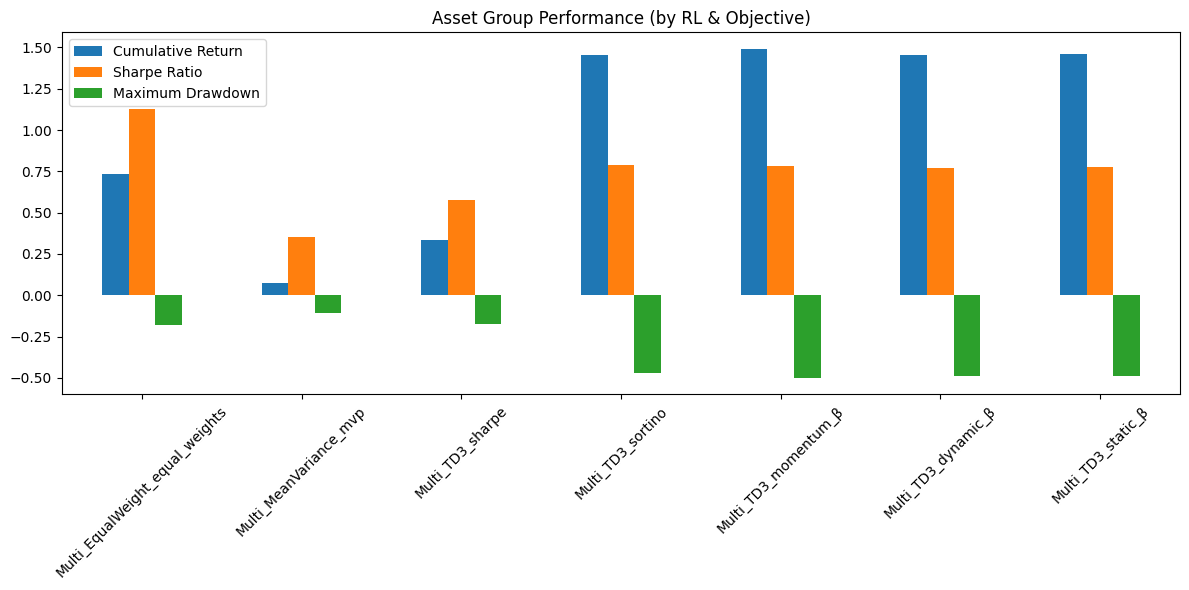

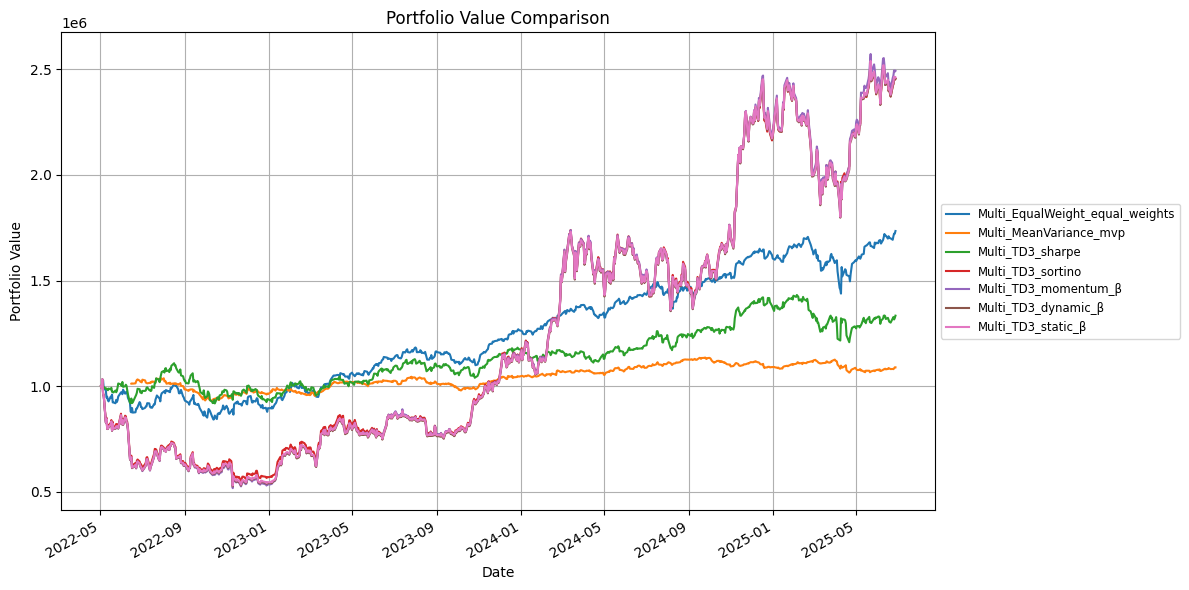

Empty DataFrame
Columns: []
Index: []


In [ ]:
 # 실험 실행
results = {}
previous_group = None

for group, assets, algo_name, algo_class, objective in Multi_all_experiments_td3:
    key = f"{group}_{algo_name}_{objective}"
    print(f"▶ Running: {key}")
    try:
        results[key] = train_and_evaluate(assets, algo_class, objective)
    except Exception as e:
        print(f"Error in {key}: {str(e)}")
        results[key] = None
    # 그룹이 바뀔때만 기술통계 출력
    if previous_group != group:
        show_summary = True
        previous_group = group
    else:
        show_summary = False


# 성과 요약 (오류 제외)
valid_results = {k: v for k, v in results.items() if v is not None}
metrics_table = pd.DataFrame({k: performance_metrics(v) for k, v in valid_results.items()}).T
print(metrics_table)

# 성과 막대그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# 포트폴리오 가치 시계열 그래프
results_df = pd.DataFrame(valid_results)
ax = results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
# 🔽 범례를 오른쪽 바깥에 배치
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small')
plt.tight_layout()
plt.show()


# sharpe 를 baseline으로 하여 통계적으로 의미가 있는지 비교함
summary = []

for (group, assets, algo, model_cls, obj) in Multi_experiments:
    if obj == "sharpe":
        continue  # baseline 제외

    base_key = f"{group}_{algo}_sharpe"
    compare_key = f"{group}_{algo}_{obj}"

    # Add check for None before calling compare_strategies
    if base_key in results and compare_key in results and results[base_key] is not None and results[compare_key] is not None:
        res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
        summary.append({
            "Group": group,
            "Algorithm": algo,
            "CompareWith": obj,
            "t_p": res["t_p"],
            "u_p": res["u_p"]
        })

summary_df = pd.DataFrame(summary)
#import ace_tools as tools; tools.display_dataframe_to_user(name="Comparison Results", dataframe=summary_df)
print(summary_df)

In [ ]:
summary = []

for (group, assets, algo, model_cls, obj) in Multi_all_experiments_td3:
    if obj == "equal_weights":
        continue

    base_key = f"{group}_EqualWeight_equal_weights"  # EqualWeight로 고정
    compare_key = f"{group}_{algo}_{obj}"


    print(">> base:", base_key, "| compare:", compare_key)

    if base_key in results and compare_key in results:
        if results[base_key] is not None and results[compare_key] is not None:
            res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
            summary.append({
                "Group": group,
                "Algorithm": algo,
                "CompareWith": obj,
                "t_p": res["t_p"],
                "u_p": res["u_p"]
            })

        else:
            print(">> One of the results is None")
    else:
        print(">> Key missing in results")

summary_df = pd.DataFrame(summary)
print(summary_df)

>> base: Multi_EqualWeight_equal_weights | compare: Multi_MeanVariance_mvp

🔎 [Multi_EqualWeight_equal_weights vs Multi_MeanVariance_mvp]
▶ t-test p-value: 0.0360 → 유의미함
▶ Mann–Whitney U-test p-value: 0.0045 → 유의미함
>> base: Multi_EqualWeight_equal_weights | compare: Multi_TD3_sharpe

🔎 [Multi_EqualWeight_equal_weights vs Multi_TD3_sharpe]
▶ t-test p-value: 0.5287 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.5095 → 유의미하지 않음
>> base: Multi_EqualWeight_equal_weights | compare: Multi_TD3_sortino

🔎 [Multi_EqualWeight_equal_weights vs Multi_TD3_sortino]
▶ t-test p-value: 0.4936 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.7110 → 유의미하지 않음
>> base: Multi_EqualWeight_equal_weights | compare: Multi_TD3_momentum_β

🔎 [Multi_EqualWeight_equal_weights vs Multi_TD3_momentum_β]
▶ t-test p-value: 0.4809 → 유의미하지 않음
▶ Mann–Whitney U-test p-value: 0.7263 → 유의미하지 않음
>> base: Multi_EqualWeight_equal_weights | compare: Multi_TD3_dynamic_β

🔎 [Multi_EqualWeight_equal_weights vs Multi_TD3_dynamic_β]
▶ t-test p

In [ ]:
# End Time
end_time = time.time()

# Elapsed Time
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.4f} 초")

time.strftime('%y%m%d - %X')

Elapsed Time: 14737.6651 초


'250808 - 15:59:27'